## Load data

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import pickle
from collections import Counter

import pandas
import numpy
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

# from dominance_analysis import Dominance
from pymatgen import Composition as C
from tqdm import tqdm, trange
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

from s4.data import open_data
from s4.ml.wls import linear_model_analysis, feature_importance
from s4.ml.plotting import periodic_table_heatmap
from s4.ml.nonlinear import model_cv_analysis, custom_grid_search

plt.rcParams["font.size"] = "20"
plt.rcParams["font.family"] = "Helvetica"

logging.basicConfig(level=logging.INFO)

# Load ML data from the dump file from my runs.
with open('intermediate_data/DMM_TrainingData.pypickle', 'rb') as f:
    ml_data = pickle.load(f)
    
# Replace "." in feature names
ml_data = ml_data.rename(axis=1, mapper=lambda x: x.replace('3.15', '3_15'))

# We need to scale down melting points because they cause numerical instabilities in statsmodels
scale_down = [
    'feature_exp_min_mp',
    'feature_exp_max_mp',
    'feature_exp_mean_mp',
    'feature_exp_div_mp',
    'feature_thermo_lb_temp',
    'feature_thermo_ub_temp',
]
for feat in scale_down:
    ml_data[feat] = ml_data[feat] / 1000
    
scale_up = [
    'feature_thermo_total_ddf',
    'feature_thermo_first_ddf',
]
# # We need to scale up thermo quantities because they cause numerical instabilities in statsmodels
for feat in scale_up:
    ml_data[feat] = ml_data[feat] * 1000

# Exclude those compositions that are interpolated: they have some weird thermo implications
# ml_data = ml_data.query('feature_syn_n_target_mixture == 1')

# Only take the first reaction, no duplicates within the same recipe
ml_data = ml_data.drop_duplicates(subset=('meta_k', 'meta_i')).set_index(keys=['meta_k', 'meta_i'])

# Split the dataset and select carbonate/oxide and oxide/oxide reactions
carb_oxi = ml_data.query('feature_syn_n_carbonates>0').dropna()
oxi_oxi = ml_data.query('feature_syn_n_carbonates==0').dropna()

def simple_outlier_detection(pd, column):
    qt = numpy.quantile(pd[column].values, [0.05, 0.95])
    lb, ub = 2*qt[0] - qt[1], 2*qt[1] - qt[0]
    new_pd = pd.loc[pd[column].apply(lambda x: lb <= x <= ub)]
    if len(new_pd) < len(pd):
        print('Dropped %d rows for column %s' % ((len(pd)-len(new_pd)), column))
    return new_pd

print('==== Outlier detection for carbonate/oxide reactions ====')
for name in carb_oxi.columns:
    if not name.startswith('feature_') or carb_oxi[name].dtype.kind != 'f':
        continue
    carb_oxi = simple_outlier_detection(carb_oxi, name)
    
print('==== Outlier detection for oxide/oxide reactions ====')
for name in oxi_oxi.columns:
    if not name.startswith('feature_') or oxi_oxi[name].dtype.kind != 'f':
        continue
    oxi_oxi = simple_outlier_detection(oxi_oxi, name)

# carb_oxi.to_csv('Carb.csv')
# oxi_oxi.to_csv('Oxi.csv')

print(f'Precursor type: carbonate + oxide, there are {len(carb_oxi)} entries')
print(f'Precursor type: oxide + oxide, there are {len(oxi_oxi)} entries')

/Users/hhuo/miniconda3/envs/s4/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/hhuo/miniconda3/envs/s4/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


==== Outlier detection for carbonate/oxide reactions ====
Dropped 6 rows for column feature_thermo_1073_15_total_df
Dropped 82 rows for column feature_thermo_1073_15_first_df_frac
Dropped 17 rows for column feature_thermo_1073_15_last_df_frac
Dropped 13 rows for column feature_thermo_1173_15_first_df_frac
Dropped 1 rows for column feature_thermo_1173_15_last_df_frac
Dropped 1 rows for column feature_thermo_1273_15_last_df
Dropped 8 rows for column feature_thermo_1273_15_first_df_frac
Dropped 14 rows for column feature_thermo_1373_15_first_df_frac
Dropped 1 rows for column feature_thermo_1373_15_last_df_frac
Dropped 13 rows for column feature_thermo_1473_15_last_df
Dropped 1 rows for column feature_thermo_1473_15_first_df_frac
Dropped 20 rows for column feature_thermo_1573_15_last_df
Dropped 3 rows for column feature_thermo_total_ddf
Dropped 1 rows for column feature_min_p_h_300K
==== Outlier detection for oxide/oxide reactions ====
Dropped 10 rows for column feature_thermo_lb_temp
Drop

In [2]:
# Make sure most features have std between [0.1, 5]

print('=== Carbonate/oxide ===')
for name, value in dict(carb_oxi.std()).items():
    if not 0.1 <= value <= 5 and not name.startswith('feature_ele'):
        print(name, 'has std value', value)
        
print('=== Oxide/oxide ===')
for name, value in dict(oxi_oxi.std()).items():
    if not 0.1 <= value <= 5 and not name.startswith('feature_ele'):
        print(name, 'has std value', value)

=== Carbonate/oxide ===
y_temperature has std value 238.96577994842184
meta_precursor_freq has std value 57.48519836702975
=== Oxide/oxide ===
y_temperature has std value 267.6938913329341
feature_syn_n_carbonates has std value 0.0
meta_precursor_freq has std value 34.378050506639404


/var/folders/rm/00mg5bsj00v32qgy51j9tpqw0000gn/T/ipykernel_53137/3918979047.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  for name, value in dict(carb_oxi.std()).items():
/var/folders/rm/00mg5bsj00v32qgy51j9tpqw0000gn/T/ipykernel_53137/3918979047.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  for name, value in dict(oxi_oxi.std()).items():


In [3]:
predictive_features = [
    'feature_ele_Li', 'feature_ele_Be', 'feature_ele_B', 'feature_ele_C', 'feature_ele_N', 'feature_ele_O',
    'feature_ele_F', 'feature_ele_Na', 'feature_ele_Mg', 'feature_ele_Al', 'feature_ele_Si', 'feature_ele_P',
    'feature_ele_S', 'feature_ele_Cl', 'feature_ele_K', 'feature_ele_Ca', 'feature_ele_Sc', 'feature_ele_Ti',
    'feature_ele_V', 'feature_ele_Cr', 'feature_ele_Mn', 'feature_ele_Fe', 'feature_ele_Co', 'feature_ele_Ni',
    'feature_ele_Cu', 'feature_ele_Zn', 'feature_ele_Ga', 'feature_ele_Ge', 'feature_ele_As', 'feature_ele_Se',
    'feature_ele_Br', 'feature_ele_Rb', 'feature_ele_Sr', 'feature_ele_Y', 'feature_ele_Zr', 'feature_ele_Nb',
    'feature_ele_Mo', 'feature_ele_Ru', 'feature_ele_Rh', 'feature_ele_Pd', 'feature_ele_Ag', 'feature_ele_Cd',
    'feature_ele_In', 'feature_ele_Sn', 'feature_ele_Sb', 'feature_ele_Te', 'feature_ele_Cs', 'feature_ele_Ba',
    'feature_ele_La', 'feature_ele_Ce', 'feature_ele_Pr', 'feature_ele_Nd', 'feature_ele_Sm', 'feature_ele_Eu',
    'feature_ele_Gd', 'feature_ele_Tb', 'feature_ele_Dy', 'feature_ele_Ho', 'feature_ele_Er', 'feature_ele_Tm',
    'feature_ele_Yb', 'feature_ele_Lu', 'feature_ele_Hf', 'feature_ele_Ta', 'feature_ele_W', 'feature_ele_Re',
    'feature_ele_Os', 'feature_ele_Ir', 'feature_ele_Hg', 'feature_ele_Tl', 'feature_ele_Pb', 'feature_ele_Bi',
    'feature_ele_Th', 'feature_ele_U', 

    'feature_text_is_ball_milling', 'feature_text_is_multi_heating', 'feature_text_is_regrinding',
    'feature_text_is_binder', 'feature_text_is_distilled', 'feature_text_is_zirconia',
    'feature_text_is_diameter', 'feature_text_is_sintered', 'feature_text_is_wet', 'feature_text_is_PVA',
    'feature_text_is_polycrystal', 'feature_text_is_phosphors', 'feature_text_is_homoge',
    'feature_text_is_ground', 'feature_text_is_again',

#     'feature_thermo_lb_temp', 'feature_thermo_ub_temp',

    'feature_thermo_1073_15_total_df', 'feature_thermo_1073_15_first_df', 'feature_thermo_1073_15_last_df',
    'feature_thermo_1073_15_first_df_frac', 'feature_thermo_1073_15_last_df_frac',

    'feature_thermo_1173_15_total_df', 'feature_thermo_1173_15_first_df', 'feature_thermo_1173_15_last_df',
    'feature_thermo_1173_15_first_df_frac', 'feature_thermo_1173_15_last_df_frac',

    'feature_thermo_1273_15_total_df', 'feature_thermo_1273_15_first_df', 'feature_thermo_1273_15_last_df',
    'feature_thermo_1273_15_first_df_frac', 'feature_thermo_1273_15_last_df_frac',

    'feature_thermo_1373_15_total_df', 'feature_thermo_1373_15_first_df', 'feature_thermo_1373_15_last_df',
    'feature_thermo_1373_15_first_df_frac', 'feature_thermo_1373_15_last_df_frac',

    'feature_thermo_1473_15_total_df', 'feature_thermo_1473_15_first_df', 'feature_thermo_1473_15_last_df',
    'feature_thermo_1473_15_first_df_frac', 'feature_thermo_1473_15_last_df_frac',

    'feature_thermo_1573_15_total_df', 'feature_thermo_1573_15_first_df', 'feature_thermo_1573_15_last_df',
    'feature_thermo_1573_15_first_df_frac', 'feature_thermo_1573_15_last_df_frac', 

    'feature_thermo_total_ddf', 'feature_thermo_first_ddf', 

    'feature_exp_min_mp', 'feature_exp_max_mp', 'feature_exp_mean_mp', 'feature_exp_div_mp',
    'feature_avg_p_h_300K', 'feature_min_p_h_300K', 'feature_max_p_h_300K', 'feature_diff_p_h_300K',
    'feature_avg_dgf_300K', 'feature_min_dgf_300K', 'feature_max_dgf_300K', 'feature_diff_dgf_300K',
]

predictive_features_elemental = [
    'feature_ele_Li', 'feature_ele_Be', 'feature_ele_B', 'feature_ele_C', 'feature_ele_N', 'feature_ele_O',
    'feature_ele_F', 'feature_ele_Na', 'feature_ele_Mg', 'feature_ele_Al', 'feature_ele_Si', 'feature_ele_P',
    'feature_ele_S', 'feature_ele_Cl', 'feature_ele_K', 'feature_ele_Ca', 'feature_ele_Sc', 'feature_ele_Ti',
    'feature_ele_V', 'feature_ele_Cr', 'feature_ele_Mn', 'feature_ele_Fe', 'feature_ele_Co', 'feature_ele_Ni',
    'feature_ele_Cu', 'feature_ele_Zn', 'feature_ele_Ga', 'feature_ele_Ge', 'feature_ele_As', 'feature_ele_Se',
    'feature_ele_Br', 'feature_ele_Rb', 'feature_ele_Sr', 'feature_ele_Y', 'feature_ele_Zr', 'feature_ele_Nb',
    'feature_ele_Mo', 'feature_ele_Ru', 'feature_ele_Rh', 'feature_ele_Pd', 'feature_ele_Ag', 'feature_ele_Cd',
    'feature_ele_In', 'feature_ele_Sn', 'feature_ele_Sb', 'feature_ele_Te', 'feature_ele_Cs', 'feature_ele_Ba',
    'feature_ele_La', 'feature_ele_Ce', 'feature_ele_Pr', 'feature_ele_Nd', 'feature_ele_Sm', 'feature_ele_Eu',
    'feature_ele_Gd', 'feature_ele_Tb', 'feature_ele_Dy', 'feature_ele_Ho', 'feature_ele_Er', 'feature_ele_Tm',
    'feature_ele_Yb', 'feature_ele_Lu', 'feature_ele_Hf', 'feature_ele_Ta', 'feature_ele_W', 'feature_ele_Re',
    'feature_ele_Os', 'feature_ele_Ir', 'feature_ele_Hg', 'feature_ele_Tl', 'feature_ele_Pb', 'feature_ele_Bi',
    'feature_ele_Th', 'feature_ele_U', 

    'feature_text_is_ball_milling', 'feature_text_is_multi_heating', 'feature_text_is_regrinding',
    'feature_text_is_binder', 'feature_text_is_distilled', 'feature_text_is_zirconia',
    'feature_text_is_diameter', 'feature_text_is_sintered', 'feature_text_is_wet', 'feature_text_is_PVA',
    'feature_text_is_polycrystal', 'feature_text_is_phosphors', 'feature_text_is_homoge',
    'feature_text_is_ground', 'feature_text_is_again',
]

### Inspect extraction accuracy

In [3]:
inspect_frame = carb_oxi[['meta_doi', 'y_speed', 'y_temperature', 'meta_precursors', 'meta_text']].sample(n=100, random_state=42)
inspect_frame

,,meta_doi,y_speed,y_temperature,meta_precursors,meta_text
meta_k,meta_i,,,,,
10991,0,10.1016/j.spmi.2015.09.016,-0.477121,1250.0,"(BaCO3, ZrO2)",BaZrO3:Eu3+ phosphors with various concentrati...
8119,0,10.1016/j.jcrysgro.2006.09.041,-1.000000,500.0,"(Li2CO3, Nb2O5)",Li2CO3 powder of 99.99% purity and Nb2O5 powde...
26642,0,10.1021/acs.chemmater.5b02441,-1.380211,1600.0,"(BaCO3, ZrO2)",Samples of 10 mol% (moles of Sc per mole of Ba...
10654,0,10.1103/PhysRevB.83.144404,-1.380211,1200.0,"(Ho2O3, MnCO3)",Polycrystalline samples of Ho1-xErxMnO3 (0. x....
6998,0,10.1007/s10854-016-4944-0,-0.602060,1250.0,"(SiO2, SrCO3)",The dysprosium doped strontium metasilicate wh...
...,...,...,...,...,...,...
10846,0,10.1016/j.jpowsour.2006.04.027,-1.477121,800.0,"(Co3O4, Li2CO3)",The LiCoO2 was synthesized by conventional sol...
25798,0,10.1016/j.jssc.2014.08.015,-0.698970,1350.0,"(CaCO3, TiO2)","A series of Ca3-xTi2O7:xEu3+, Ca3-x-yTi2O7:xEu..."
12760,0,10.1016/j.matlet.2012.07.017,-0.602060,1350.0,"(BaCO3, TiO2)","Stoichiometric amount of BaCO3, K2CO3, Bi2O3 a..."


In [4]:
# for j, (i, row) in enumerate(inspect_frame.iterrows()):
#     print(j)
#     print('='*50)
#     print(row['meta_text'])
#     row['y_speed'] = 1/10**(row['y_speed'])
#     print({x: y for x, y in row.items() if x!='meta_text'})

- Time extraction accuracy: 84%
- Temperature extraction accuracy: >95%

## Manuscript results

### (Sec. Results.1) Dominance importance

#### Compute dominance levels

In [11]:
print('Compute DI values for carbonate/oxide reactions, prediction target temperature.')
## Full calculation takes lots of time...
# temp_co_domreg = Dominance(
#     data=carb_oxi[predictive_features + ['y_temperature']], 
#     target='y_temperature', 
#     sample_weight=1.0/(1+numpy.log(carb_oxi['meta_precursor_freq'].values))**2,
#     top_k_features=15)
# temp_co_domreg_result = temp_co_domreg.incremental_rsquare()

# # temp_co_domreg.plot_incremental_rsquare()
# temp_co_domreg.dominance_stats() \
#     .apply(pandas.to_numeric) \
#     .style.background_gradient(cmap ='coolwarm', axis=0)

temp_co_importance = feature_importance(
    data_frame=carb_oxi[predictive_features + ['y_temperature']], 
    features=predictive_features,
    y_name='y_temperature', 
    do_wls=True, weights=1.0/(1+numpy.log(carb_oxi['meta_precursor_freq'].values))**2,
    processes=4, submodel_search=400)

print('Compute DI values for oxide/oxide reactions, prediction target temperature.')

# temp_oo_domreg = Dominance(
#     data=oxi_oxi[feat_temp_pred + ['y_temperature']], 
#     target='y_temperature', 
#     sample_weight=1.0/(1+numpy.log(oxi_oxi['meta_precursor_freq'].values))**2,
#     top_k_features=15)
# temp_oo_domreg_result = temp_oo_domreg.incremental_rsquare()

# # temp_co_domreg.plot_incremental_rsquare()
# temp_oo_domreg.dominance_stats() \
#     .apply(pandas.to_numeric) \
#     .style.background_gradient(cmap ='coolwarm', axis=0)

temp_oo_importance = feature_importance(
    data_frame=oxi_oxi[predictive_features + ['y_temperature']], 
    features=predictive_features,
    y_name='y_temperature', 
    do_wls=True, weights=1.0/(1+numpy.log(oxi_oxi['meta_precursor_freq'].values))**2,
    processes=4, submodel_search=400)

print('Compute DI values for carbonate/oxide reactions, prediction target time.')

# time_co_domreg = Dominance(
#     data=carb_oxi[feat_time_pred + ['y_speed']], 
#     target='y_speed', 
#     sample_weight=1.0/(1+numpy.log(carb_oxi['meta_precursor_freq'].values))**2,
#     top_k_features=15)
# time_co_domreg_result = time_co_domreg.incremental_rsquare()

# time_co_domreg.dominance_stats() \
#     .apply(pandas.to_numeric) \
#     .style.background_gradient(cmap ='coolwarm', axis=0)

time_co_importance = feature_importance(
    data_frame=carb_oxi[predictive_features + ['y_speed']], 
    features=predictive_features,
    y_name='y_speed', 
    do_wls=True, weights=1.0/(1+numpy.log(carb_oxi['meta_precursor_freq'].values))**2,
    processes=4, submodel_search=400)

print('Compute DI values for oxide/oxide reactions, prediction target time.')

# time_oo_domreg = Dominance(
#     data=oxi_oxi[feat_time_pred + ['y_speed']], 
#     target='y_speed', 
#     sample_weight=1.0/(1+numpy.log(oxi_oxi['meta_precursor_freq'].values))**2,
#     top_k_features=15)
# time_oo_domreg_result = time_oo_domreg.incremental_rsquare()

# # temp_co_domreg.plot_incremental_rsquare()
# time_oo_domreg.dominance_stats() \
#     .apply(pandas.to_numeric) \
#     .style.background_gradient(cmap ='coolwarm', axis=0)

time_oo_importance = feature_importance(
    data_frame=oxi_oxi[predictive_features + ['y_speed']], 
    features=predictive_features,
    y_name='y_speed', 
    do_wls=True, weights=1.0/(1+numpy.log(oxi_oxi['meta_precursor_freq'].values))**2,
    processes=4, submodel_search=400)

Waiting for results: 100%|██████████| 133/133 [1:46:11<00:00, 47.90s/it]


#### Make plots (Fig. 2)

In [12]:
# temp_co_domreg.dominance_stats().to_csv('intermediate_data/Dominance_Importance_Temp_CO.csv')
# temp_oo_domreg.dominance_stats().to_csv('intermediate_data/Dominance_Importance_Temp_OO.csv')
# time_co_domreg.dominance_stats().to_csv('intermediate_data/Dominance_Importance_Time_CO.csv')
# time_oo_domreg.dominance_stats().to_csv('intermediate_data/Dominance_Importance_Time_OO.csv')

# temp_co_importance.to_csv('intermediate_data/Dominance_Importance_Temp_CO.csv')
# temp_oo_importance.to_csv('intermediate_data/Dominance_Importance_Temp_OO.csv')
# time_co_importance.to_csv('intermediate_data/Dominance_Importance_Time_CO.csv')
# time_oo_importance.to_csv('intermediate_data/Dominance_Importance_Time_OO.csv')

In [165]:
temp_co_di = pandas.read_csv('intermediate_data/Dominance_Importance_Temp_CO.csv').set_index('Unnamed: 0')
temp_oo_di = pandas.read_csv('intermediate_data/Dominance_Importance_Temp_OO.csv').set_index('Unnamed: 0')
time_co_di = pandas.read_csv('intermediate_data/Dominance_Importance_Time_CO.csv').set_index('Unnamed: 0')
time_oo_di = pandas.read_csv('intermediate_data/Dominance_Importance_Time_OO.csv').set_index('Unnamed: 0')

In [78]:
# from s4.ml.plotting import scatter_matrix_plot

# scatter_matrix_plot(carb_oxi[['y_temperature'] + temp_co_di.index.values.tolist()], figsize=(20, 20))
# plt.savefig('figures/Fig.S5.ScatterMatrix.TempCarbOxi.pdf')
# plt.close()

# scatter_matrix_plot(oxi_oxi[['y_temperature'] + temp_oo_di.index.values.tolist()], figsize=(20, 20))
# plt.savefig('figures/Fig.S5.ScatterMatrix.TempOxiOxi.pdf')
# plt.close()

# scatter_matrix_plot(carb_oxi[['y_speed'] + time_co_di.index.values.tolist()], figsize=(20, 20))
# plt.savefig('figures/Fig.S5.ScatterMatrix.TimeCarbOxi.pdf')
# plt.close()

# scatter_matrix_plot(oxi_oxi[['y_speed'] + time_oo_di.index.values.tolist()], figsize=(20, 20))
# plt.savefig('figures/Fig.S5.ScatterMatrix.TimeOxiOxi.pdf')
# plt.close()

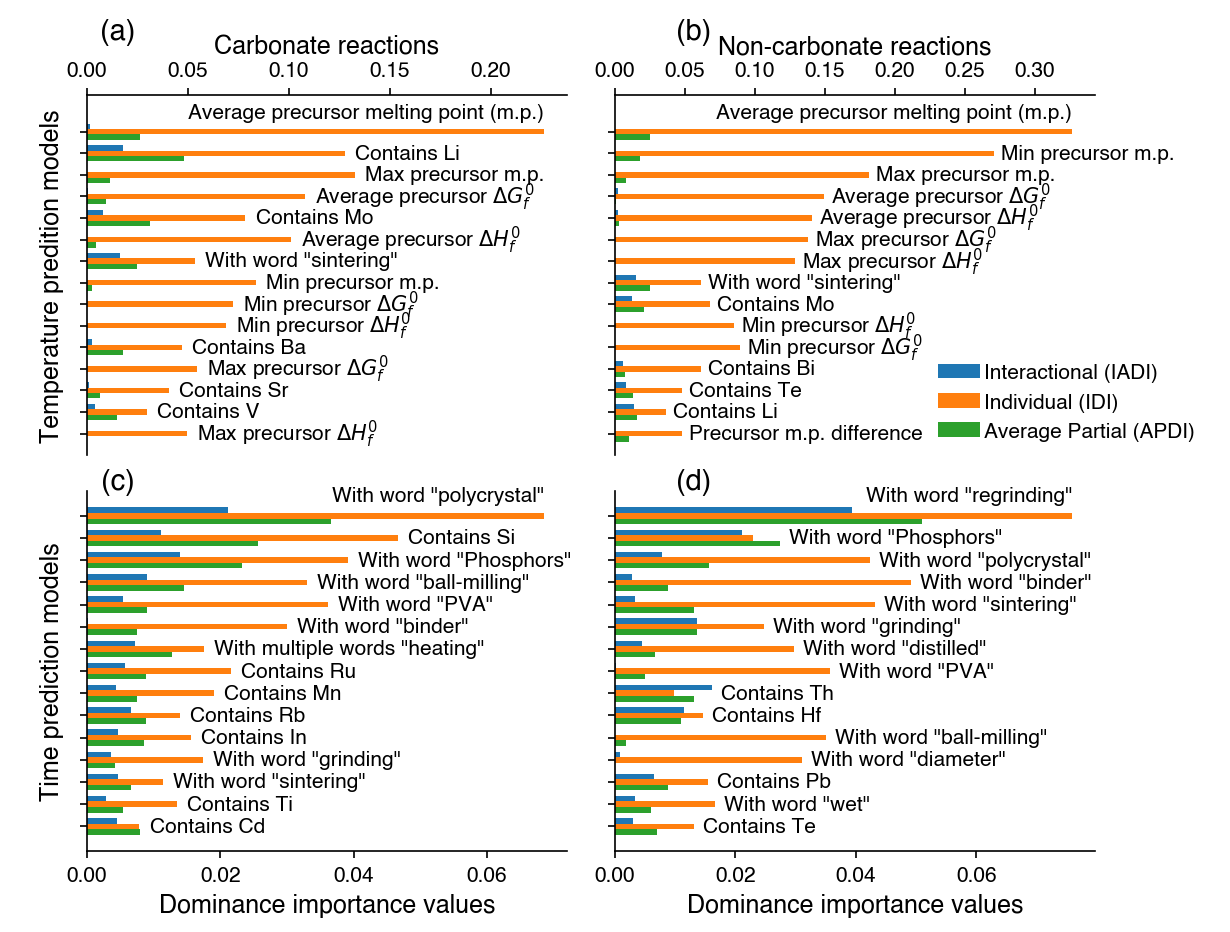

In [180]:
feature_names = {
    'feature_exp_mean_mp': "Average precursor melting point (m.p.)",
    'feature_exp_min_mp': "Min precursor m.p.",
    'feature_exp_max_mp': "Max precursor m.p.",
    'feature_exp_div_mp': "Precursor m.p. difference",
    'feature_min_dgf_300K': "Min precursor $\Delta G_f^0$",
    'feature_avg_dgf_300K': "Average precursor $\Delta G_f^0$",
    'feature_max_dgf_300K': "Max precursor $\Delta G_f^0$",
    'feature_min_p_h_300K': "Min precursor $\Delta H_f^0$",
    'feature_avg_p_h_300K': "Average precursor $\Delta H_f^0$",
    'feature_max_p_h_300K': "Max precursor $\Delta H_f^0$",
    'feature_ele_Li': 'Contains Li',
    'feature_ele_Na': 'Contains Na',
    'feature_ele_Ba': 'Contains Ba',
    'feature_ele_Te': 'Contains Te',
    'feature_ele_Mo': 'Contains Mo',
    'feature_ele_Bi': 'Contains Bi',
    'feature_ele_K': 'Contains K',
    'feature_ele_P': 'Contains P',
    'feature_ele_O': 'Contains O',
    'feature_ele_Y': 'Contains Y',
    'feature_ele_Ce': 'Contains Ce',
    'feature_ele_Sr': 'Contains Sr',
    'feature_ele_Nd': 'Contains Nd',
    'feature_ele_Si': 'Contains Si',
    'feature_ele_Zr': 'Contains Zr',
    'feature_ele_Mn': 'Contains Mn',
    'feature_ele_Ti': 'Contains Ti',
    'feature_ele_Te': 'Contains Te',
    'feature_ele_La': 'Contains La',
    'feature_ele_Cd': 'Contains Cd',
    'feature_ele_Hf': 'Contains Hf',
    'feature_ele_Rb': 'Contains Rb',
    'feature_ele_Ru': 'Contains Ru',
    'feature_ele_Th': 'Contains Th',
    'feature_ele_In': 'Contains In',
    'feature_ele_Ga': 'Contains Ga',
    'feature_ele_Pb': 'Contains Pb',
    'feature_ele_Fe': 'Contains Fe',
    'feature_ele_V': 'Contains V',
    'feature_text_is_sintered': 'With word "sintering"',
    'feature_text_is_polycrystal': 'With word "polycrystal"',
    'feature_text_is_binder': 'With word "binder"',
    'feature_text_is_PVA': 'With word "PVA"',
    'feature_text_is_distilled': 'With word "distilled"',
    'feature_text_is_diameter': 'With word "diameter"',
    'feature_text_is_phosphors': 'With word "Phosphors"',
    'feature_text_is_ball_milling': 'With word "ball-milling"',
    'feature_text_is_wet': 'With word "wet"',
    'feature_text_is_multi_heating': 'With multiple words "heating"',
    'feature_text_is_ground': 'With word "grinding"',
    'feature_text_is_regrinding': 'With word "regrinding"',
    'feature_thermo_1k_total_ddf': 'Derivative of total driving force @ 1k °C',
    'feature_thermo_1k_first_df': 'First pairwise reaction driving force @ 1k °C',
    'feature_thermo_1k_first_ddf': 'Derivative of first driving force @ 1k °C',
}

fig = plt.figure(figsize=(8, 6), dpi=150)
ax1 = fig.add_axes([0.06, 0.51, 0.40, 0.40])
ax2 = fig.add_axes([0.50, 0.51, 0.40, 0.40])
ax3 = fig.add_axes([0.06, 0.07, 0.40, 0.40])
ax4 = fig.add_axes([0.50, 0.07, 0.40, 0.40])
ax_labels = fig.add_axes([0, 0, 1, 1])

def plot_to_ax(di_stats, ax, pad=0.005):
    nlevels = len(di_stats)
    ax.barh(
        numpy.arange(nlevels)-0.25,
        di_stats['Interactional Dominance'],
        height=0.25,
        align='center',
        label='Interactional (IADI)')
    ax.barh(
        numpy.arange(nlevels),
        di_stats['Individual Dominance'],
        height=0.25,
        align='center',
        label='Individual (IDI)')
    ax.barh(
        numpy.arange(nlevels)+0.25,
        di_stats['Estimated Average Partial Dominance'],
        height=0.25,
        align='center',
        label='Average Partial (APDI)')
    ax.set_yticks(numpy.arange(nlevels))
    ax.set_yticklabels(['']*nlevels, fontsize=10)
    ax.invert_yaxis()
#     ax.set_xlabel('Dominance Importance', fontsize=10)

    max_dominance = di_stats[[
        'Interactional Dominance', 'Individual Dominance', 'Estimated Average Partial Dominance']].max(axis=1)
    ax.text(
        max_dominance.values[0], -0.9,
        feature_names.get(max_dominance.index[0], max_dominance.index[0]),
        ha='right', va='center', fontsize=10)
    for i in range(1, nlevels):
        ax.text(
            max_dominance.values[i] + pad, i,
            feature_names.get(max_dominance.index[i], max_dominance.index[i]),
            ha='left', va='center', fontsize=10)

plot_to_ax(temp_co_di.iloc[:15].clip(lower=0.0), ax1, pad=0.005)
ax1.xaxis.tick_top()
ax1.tick_params(axis='both', labelsize=10)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylim([15, -1.7])
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Carbonate reactions', fontsize=12)
ax1.set_ylabel('Temperature predition models', fontsize=12)

plot_to_ax(temp_oo_di.iloc[:15].clip(lower=0.0), ax2, pad=0.005)
ax2.xaxis.tick_top()
ax2.tick_params(axis='both', labelsize=10)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Non-carbonate reactions', fontsize=12)
ax2.set_ylim([15, -1.7])

plot_to_ax(time_co_di.iloc[:15].clip(lower=0.0), ax3, pad=0.0015)
ax3.tick_params(axis='both', labelsize=10)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_xlabel('Dominance importance values', fontsize=12)
ax3.set_ylabel('Time prediction models', fontsize=12)

plot_to_ax(time_oo_di.iloc[:15].clip(lower=0.0), ax4, pad=0.0015)
ax4.tick_params(axis='both', labelsize=10)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_xlabel('Dominance importance values', fontsize=12)

ax_labels.text(0.10, 0.98, '(a)', ha='right', va='center', fontsize=14)
ax_labels.text(0.58, 0.98, '(b)', ha='right', va='center', fontsize=14)
ax_labels.text(0.10, 0.48, '(c)', ha='right', va='center', fontsize=14)
ax_labels.text(0.58, 0.48, '(d)', ha='right', va='center', fontsize=14)
ax_labels.patch.set_alpha(0.0)
ax_labels.set_xlim([0, 1])
ax_labels.set_ylim([0, 1])
ax_labels.set_xticks([])
ax_labels.set_yticks([])
[v.set_visible(False) for v in ax_labels.spines.values()]

legend_format = {
    'fontsize': 10, 'fancybox': False, 'frameon': False,
    'borderpad': 0., 'handletextpad': 0.2, 'loc': 'lower right',
    'bbox_to_anchor': (1.23, 0.01)
}
ax2.legend(**legend_format)

plt.savefig('figures/Fig.2.dominance_importance.pdf')
plt.show()

### (Sec Results.2) Building full model with forward selection

#### Temperature & Time models

In [41]:
from sklearn.linear_model import Lars

print('====== Start LARS training for carbonate/oxide reactions ======')

lars = Lars(fit_path=True, n_nonzero_coefs=30)
lars.fit(carb_oxi[predictive_features], carb_oxi['y_temperature'])
# lars.score(carb_oxi[predictive_features], carb_oxi['y_temperature'])
temp_co_lars_feature_path = [predictive_features[i] for i in lars.active_]
print('Feature path', temp_co_lars_feature_path)

print('====== Start LARS training for oxide/oxide reactions ======')

lars = Lars(fit_path=True, n_nonzero_coefs=30)
lars.fit(oxi_oxi[predictive_features], oxi_oxi['y_temperature'])
temp_oo_lars_feature_path = [predictive_features[i] for i in lars.active_]
print('Feature path', temp_oo_lars_feature_path)

print('====== Start LARS training for carbonate/oxide reactions ======')

lars = Lars(fit_path=True, n_nonzero_coefs=30)
lars.fit(carb_oxi[predictive_features], carb_oxi['y_speed'])
time_co_lars_feature_path = [predictive_features[i] for i in lars.active_]
print('Feature path', time_co_lars_feature_path)

print('====== Start LARS training for oxide/oxide reactions ======')

lars = Lars(fit_path=True, n_nonzero_coefs=30)
lars.fit(oxi_oxi[predictive_features], oxi_oxi['y_speed'])
time_oo_lars_feature_path = [predictive_features[i] for i in lars.active_]
print('Feature path', time_oo_lars_feature_path)

====== Start LARS training for carbonate/oxide reactions ======
Feature path ['feature_exp_mean_mp', 'feature_ele_Li', 'feature_ele_Mo', 'feature_text_is_sintered', 'feature_thermo_first_ddf', 'feature_ele_Bi', 'feature_ele_Na', 'feature_thermo_total_ddf', 'feature_avg_dgf_300K', 'feature_ele_Ba', 'feature_ele_K', 'feature_ele_Si', 'feature_ele_V', 'feature_ele_W', 'feature_ele_Sr', 'feature_ele_Al', 'feature_ele_Sn', 'feature_ele_Ru', 'feature_ele_N', 'feature_ele_Cu', 'feature_ele_Rb', 'feature_ele_Ti', 'feature_text_is_multi_heating', 'feature_ele_Ga', 'feature_ele_Fe', 'feature_ele_Ce', 'feature_thermo_1573_15_last_df_frac', 'feature_exp_max_mp', 'feature_text_is_ball_milling', 'feature_thermo_1073_15_first_df_frac']
====== Start LARS training for oxide/oxide reactions ======
Feature path ['feature_exp_mean_mp', 'feature_avg_dgf_300K', 'feature_exp_min_mp', 'feature_ele_Si', 'feature_text_is_sintered', 'feature_ele_Mo', 'feature_ele_Bi', 'feature_ele_Fe', 'feature_ele_Ru', 'feature

In [5]:
from s4.ml.wls import forward_selection_by_bic

temp_co_di = pandas.read_csv('intermediate_data/Dominance_Importance_Temp_CO.csv').set_index('Unnamed: 0')
temp_oo_di = pandas.read_csv('intermediate_data/Dominance_Importance_Temp_OO.csv').set_index('Unnamed: 0')
time_co_di = pandas.read_csv('intermediate_data/Dominance_Importance_Time_CO.csv').set_index('Unnamed: 0')
time_oo_di = pandas.read_csv('intermediate_data/Dominance_Importance_Time_OO.csv').set_index('Unnamed: 0')

print('====== Start BIC forward selection for carbonate/oxide reactions ======')
temp_co_feature_path, temp_co_fit_result = forward_selection_by_bic(
    data_frame=carb_oxi, 
    features_sorted=temp_co_di.index.values,
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', temp_co_feature_path)
print(temp_co_fit_result.summary())

print('====== Start BIC forward selection for oxide/oxide reactions ======')
temp_oo_feature_path, temp_oo_fit_result = forward_selection_by_bic(
    data_frame=oxi_oxi, 
    features_sorted=temp_oo_di.index.values,
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', temp_oo_feature_path)
print(temp_oo_fit_result.summary())


print('====== Start BIC forward selection for carbonate/oxide reactions ======')
time_co_feature_path, time_co_fit_result = forward_selection_by_bic(
    data_frame=carb_oxi, 
    features_sorted=time_co_di.index.values,
    y_name='y_speed',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', time_co_feature_path)
print(time_co_fit_result.summary())

print('====== Start BIC forward selection for oxide/oxide reactions ======')
time_oo_feature_path, time_oo_fit_result = forward_selection_by_bic(
    data_frame=oxi_oxi, 
    features_sorted=time_oo_di.index.values,
    y_name='y_speed',
    do_wls=True, weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', time_oo_feature_path)
print(time_oo_fit_result.summary())

====== Start BIC forward selection for carbonate/oxide reactions ======
Feature path ['feature_exp_mean_mp', 'feature_ele_Li', 'feature_avg_dgf_300K', 'feature_ele_Mo', 'feature_avg_p_h_300K', 'feature_text_is_sintered', 'feature_ele_Ba', 'feature_ele_Sr', 'feature_ele_V', 'feature_ele_Na', 'feature_thermo_first_ddf', 'feature_ele_Bi', 'feature_thermo_total_ddf', 'feature_ele_Al', 'feature_ele_Rb', 'feature_ele_Si', 'feature_ele_W', 'feature_ele_N', 'feature_ele_Ga', 'feature_ele_Ce', 'feature_ele_Te', 'feature_ele_Sn', 'feature_text_is_ball_milling', 'feature_ele_Br', 'feature_ele_Nb', 'feature_ele_K', 'feature_ele_Yb', 'feature_ele_Cs', 'feature_ele_Tl', 'feature_ele_Hf', 'feature_ele_S', 'feature_ele_Er', 'feature_diff_p_h_300K', 'feature_ele_Ni', 'feature_ele_Ru', 'feature_ele_Ho', 'feature_ele_C', 'feature_ele_Dy']
                            WLS Regression Results                            
Dep. Variable:          y_temperature   R-squared:                       0.555
Model:    

Feature path ['feature_text_is_polycrystal', 'feature_ele_Si', 'feature_text_is_phosphors', 'feature_text_is_ball_milling', 'feature_text_is_PVA', 'feature_text_is_binder', 'feature_text_is_multi_heating', 'feature_ele_Ru', 'feature_ele_Mn', 'feature_ele_Rb', 'feature_ele_In', 'feature_text_is_ground', 'feature_text_is_sintered', 'feature_ele_Ti', 'feature_ele_Cd', 'feature_ele_Al', 'feature_ele_Hf', 'feature_ele_Sr', 'feature_ele_Cs', 'feature_ele_Pd', 'feature_ele_B', 'feature_ele_Cr', 'feature_ele_W', 'feature_ele_Ni', 'feature_ele_Cu', 'feature_ele_Ba', 'feature_ele_Co', 'feature_ele_Yb', 'feature_ele_Ce', 'feature_ele_F', 'feature_ele_Nb']
                            WLS Regression Results                            
Dep. Variable:                y_speed   R-squared:                       0.313
Model:                            WLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     44.92
Date:                Sun, 30 Ja

In [11]:
with open('intermediate_data/Full_Feature_Path.csv', 'w') as f:
    f.write('Temp_CO\t' + ','.join(temp_co_feature_path))
    f.write('\n')
    f.write('Temp_OO\t' + ','.join(temp_oo_feature_path))
    f.write('\n')
    f.write('Time_CO\t' + ','.join(time_co_feature_path))
    f.write('\n')
    f.write('Time_OO\t' + ','.join(time_oo_feature_path))
    f.write('\n')

#### Elemental effects (temperature & time) models

In [6]:
from s4.ml.wls import forward_selection_by_bic

print('====== Start BIC forward selection for carbonate/oxide reactions ======')
temp_co_feature_path_elemental, temp_co_fit_result_elemental = forward_selection_by_bic(
    data_frame=carb_oxi, 
    features_sorted=[x for x in temp_co_di.index.values if x in predictive_features_elemental],
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', temp_co_feature_path_elemental)
print(temp_co_fit_result_elemental.summary())

print('====== Start BIC forward selection for oxide/oxide reactions ======')
temp_oo_feature_path_elemental, temp_oo_fit_result_elemental = forward_selection_by_bic(
    data_frame=oxi_oxi, 
    features_sorted=[x for x in temp_oo_di.index.values if x in predictive_features_elemental],
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', temp_oo_feature_path_elemental)
print(temp_oo_fit_result_elemental.summary())


print('====== Start BIC forward selection for carbonate/oxide reactions ======')
time_co_feature_path_elemental, time_co_fit_result_elemental = forward_selection_by_bic(
    data_frame=carb_oxi, 
    features_sorted=[x for x in time_co_di.index.values if x in predictive_features_elemental],
    y_name='y_speed',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', time_co_feature_path_elemental)
print(time_co_fit_result_elemental.summary())

print('====== Start BIC forward selection for oxide/oxide reactions ======')
time_oo_feature_path_elemental, time_oo_fit_result_elemental = forward_selection_by_bic(
    data_frame=oxi_oxi, 
    features_sorted=[x for x in time_oo_di.index.values if x in predictive_features_elemental],
    y_name='y_speed',
    do_wls=True, weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', time_oo_feature_path_elemental)
print(time_oo_fit_result_elemental.summary())

====== Start BIC forward selection for carbonate/oxide reactions ======
Feature path ['feature_ele_Li', 'feature_ele_Mo', 'feature_text_is_sintered', 'feature_ele_Ba', 'feature_ele_Sr', 'feature_ele_V', 'feature_ele_Na', 'feature_ele_Bi', 'feature_ele_Al', 'feature_ele_Rb', 'feature_ele_Si', 'feature_ele_W', 'feature_ele_N', 'feature_ele_Ga', 'feature_ele_Ce', 'feature_ele_Te', 'feature_ele_Ta', 'feature_ele_Sn', 'feature_text_is_ball_milling', 'feature_ele_Ca', 'feature_ele_Br', 'feature_ele_Nb', 'feature_ele_Y', 'feature_ele_K', 'feature_ele_Yb', 'feature_ele_Ag', 'feature_ele_Cs', 'feature_ele_Tl', 'feature_ele_Hf', 'feature_ele_S', 'feature_ele_Sc', 'feature_ele_Zr', 'feature_ele_Er', 'feature_ele_Co', 'feature_ele_Sm', 'feature_ele_Ti', 'feature_text_is_PVA', 'feature_ele_Sb', 'feature_ele_La', 'feature_ele_Pb', 'feature_text_is_diameter', 'feature_ele_Pd', 'feature_ele_Cl', 'feature_ele_Lu', 'feature_ele_Eu']
                            WLS Regression Results                     

Feature path ['feature_text_is_polycrystal', 'feature_ele_Si', 'feature_text_is_phosphors', 'feature_text_is_ball_milling', 'feature_text_is_PVA', 'feature_text_is_binder', 'feature_text_is_multi_heating', 'feature_ele_Ru', 'feature_ele_Mn', 'feature_ele_Rb', 'feature_ele_In', 'feature_text_is_ground', 'feature_text_is_sintered', 'feature_ele_Ti', 'feature_ele_Cd', 'feature_ele_Al', 'feature_ele_Hf', 'feature_ele_Sr', 'feature_ele_Cs', 'feature_ele_Pd', 'feature_ele_B', 'feature_ele_Cr', 'feature_ele_W', 'feature_ele_Ni', 'feature_ele_Cu', 'feature_ele_Ba', 'feature_ele_Co', 'feature_ele_Yb', 'feature_ele_Ce', 'feature_ele_F', 'feature_ele_Nb']
                            WLS Regression Results                            
Dep. Variable:                y_speed   R-squared:                       0.313
Model:                            WLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     44.92
Date:                Sun, 30 Ja

#### Make plots (Fig. 3)

In [27]:
# full_temp_co_result['Fit result'].params.to_csv('intermediate_data/Full_Temp_CO_Params.csv')
# full_temp_oo_result['Fit result'].params.to_csv('intermediate_data/Full_Temp_OO_Params.csv')
# full_time_co_result['Fit result'].params.to_csv('intermediate_data/Full_Time_CO_Params.csv')
# full_time_oo_result['Fit result'].params.to_csv('intermediate_data/Full_Time_OO_Params.csv')

# full_temp_co_result_ele['Fit result'].params.to_csv('intermediate_data/Full_Elemental_Temp_CO_Params.csv')
# full_temp_oo_result_ele['Fit result'].params.to_csv('intermediate_data/Full_Elemental_Temp_OO_Params.csv')
# full_time_co_result_ele['Fit result'].params.to_csv('intermediate_data/Full_Elemental_Time_CO_Params.csv')
# full_time_oo_result_ele['Fit result'].params.to_csv('intermediate_data/Full_Elemental_Time_OO_Params.csv')

In [20]:
# full_temp_co_csv = pandas.read_csv('intermediate_data/Full_Elemental_Temp_CO_Params.csv').set_index('Unnamed: 0')['0']
# full_temp_oo_csv = pandas.read_csv('intermediate_data/Full_Elemental_Temp_OO_Params.csv').set_index('Unnamed: 0')['0']
# full_time_co_csv = pandas.read_csv('intermediate_data/Full_Elemental_Time_CO_Params.csv').set_index('Unnamed: 0')['0']
# full_time_oo_csv = pandas.read_csv('intermediate_data/Full_Elemental_Time_OO_Params.csv').set_index('Unnamed: 0')['0']

# full_model_temp_co_csv = pandas.read_csv('intermediate_data/Full_Temp_CO_Params.csv').set_index('Unnamed: 0')['0']
# full_model_temp_oo_csv = pandas.read_csv('intermediate_data/Full_Temp_OO_Params.csv').set_index('Unnamed: 0')['0']
# full_model_time_co_csv = pandas.read_csv('intermediate_data/Full_Time_CO_Params.csv').set_index('Unnamed: 0')['0']
# full_model_time_oo_csv = pandas.read_csv('intermediate_data/Full_Time_OO_Params.csv').set_index('Unnamed: 0')['0']

In [54]:
# from s4.ml.wls import do_linear_model

# full_model_temp_co_result = do_linear_model(
#     data_frame=carb_oxi, 
#     features=list(map(
#         lambda x: x.split('[')[0],
#         filter(
#             lambda x: x != 'Intercept', 
#             full_model_temp_co_csv.index.values
#         )
#     )), 
#     y_name='y_temperature',
#     do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
# )
# full_model_temp_oo_result = do_linear_model(
#     data_frame=oxi_oxi, 
#     features=list(map(
#         lambda x: x.split('[')[0],
#         filter(
#             lambda x: x != 'Intercept', 
#             full_model_temp_oo_csv.index.values
#         )
#     )), 
#     y_name='y_temperature',
#     do_wls=True, weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
# )
# full_model_time_co_result = do_linear_model(
#     data_frame=carb_oxi, 
#     features=list(map(
#         lambda x: x.split('[')[0],
#         filter(
#             lambda x: x != 'Intercept', 
#             full_model_time_co_csv.index.values
#         )
#     )), 
#     y_name='y_speed',
#     do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
# )
# full_model_time_oo_result = do_linear_model(
#     data_frame=oxi_oxi, 
#     features=list(map(
#         lambda x: x.split('[')[0],
#         filter(
#             lambda x: x != 'Intercept', 
#             full_model_time_oo_csv.index.values
#         )
#     )), 
#     y_name='y_speed',
#     do_wls=True, weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
# )

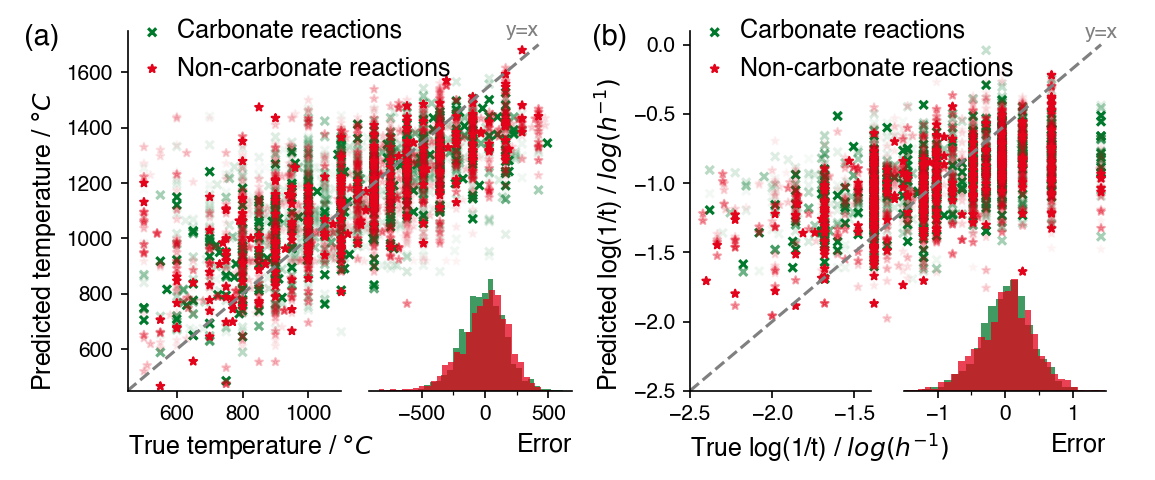

In [76]:
from s4.ml.plotting import periodic_table_heatmap_sbs
from matplotlib.colors import to_rgb
from s4.ml.plotting import generate_pt_triangulation

fig = plt.figure(figsize=(7.5, 3), dpi=150)

################################################################
################################################################
# Plot scatter plots
################################################################
################################################################

ax1_sc = fig.add_axes([0.10, 0.165, 0.38, 0.80])
ax2_sc = fig.add_axes([0.60, 0.165, 0.38, 0.80])
ax1_hist = fig.add_axes([0.315, 0.165, 0.18, 0.26])
ax2_hist = fig.add_axes([0.790, 0.165, 0.18, 0.26])

def plot_scatters(fit_result, weights, ax, ax_hist, marker, base_color, plot_label, hist_label):
    alphas = weights / weights.max()
    r, g, b = to_rgb(base_color)
    color = [(r, g, b, alpha) for alpha in alphas]
    observed = fit_result.resid + fit_result.fittedvalues
    fitted = fit_result.fittedvalues
    ax.scatter(observed, fitted, marker=marker, s=15, color=color, label=plot_label)

    ax_hist.hist(fit_result.resid, #weights=weights, 
         bins=30, color=base_color, density=True, alpha=0.75, label=hist_label)

colors = [
    '#00792c',
    '#e3031b',
    '#054561',
    '#e20619'
]
plot_scatters(
    fit_result=temp_co_fit_result, 
    weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
    ax=ax1_sc, ax_hist=ax1_hist, marker='x', base_color=colors[0], plot_label='Carbonate reactions', hist_label='')
plot_scatters(
    fit_result=temp_oo_fit_result, 
    weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
    ax=ax1_sc, ax_hist=ax1_hist, marker='*', base_color=colors[1], plot_label='Non-carbonate reactions', hist_label='')
plot_scatters(
    fit_result=time_co_fit_result, 
    weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
    ax=ax2_sc, ax_hist=ax2_hist, marker='x', base_color=colors[0], plot_label='Carbonate reactions', hist_label='')
plot_scatters(
    fit_result=time_oo_fit_result, 
    weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
    ax=ax2_sc, ax_hist=ax2_hist, marker='*', base_color=colors[1], plot_label='Non-carbonate reactions', hist_label='')

legend_format = {
    'fontsize': 12, 'fancybox': False, 'frameon': False, 
    'borderpad': 0., 'handletextpad': 0., 'loc': 'upper left',
    'bbox_to_anchor': (-0.03, 1.065)}
for lh in ax1_sc.legend(**legend_format).legendHandles: 
    lh.set_alpha(1)
for lh in ax2_sc.legend(**legend_format).legendHandles: 
    lh.set_alpha(1)

ax1_sc.spines['right'].set_visible(False)
ax1_sc.spines['top'].set_visible(False)
ax2_sc.spines['right'].set_visible(False)
ax2_sc.spines['top'].set_visible(False)

# Diagonal line
ax1_sc.plot([450, 1700], [450, 1700], color='gray', linestyle='--')
ax1_sc.text(1600, 1730, 'y=x', fontsize=10, color='gray')
ax2_sc.plot([-2.5, 0], [-2.5, 0], color='gray', linestyle='--')
ax2_sc.text(-0.1, 0.05, 'y=x', fontsize=10, color='gray')

# Scatter plots
ax1_sc.set_xlabel('True temperature / $°C$', fontsize=12, loc='left')
ax1_sc.set_ylabel("Predicted temperature / $°C$", fontsize=12, loc='bottom')
ax1_sc.tick_params(axis='both', which='major', labelsize=10)
ax1_sc.set_ylim([450, 1750])
ax1_sc.set_xlim([450, 1750])
ax1_sc.set_xticks([600, 800, 1000])
ax1_sc.spines['bottom'].set_bounds(450, 1100)

ax2_sc.set_xlabel('True log(1/t) / $log(h^{-1})$', fontsize=12, loc='left')
ax2_sc.set_ylabel("Predicted log(1/t) / $log(h^{-1})$", fontsize=12, loc='bottom')
ax2_sc.tick_params(axis='both', which='major', labelsize=10)
ax2_sc.set_ylim([-2.5, 0.1])
ax2_sc.set_xlim([-2.5, 0.1])
ax2_sc.set_xticks([-2.5, -2.0, -1.5])
ax2_sc.spines['bottom'].set_bounds(-2.5, -1.4)

# Histograms
ax1_hist.tick_params(axis='both', which='major', labelsize=10)
ax1_hist.set_xlabel('Error', fontsize=12, loc='right')
ax1_hist.set_yticks([])
ax1_hist.set_yticklabels([])
# ax1_hist.set_ylim([0, 0.0030])
ax1_hist.set_xticks([-500, 0, 500])
ax1_hist.set_xticks([-250, 250], minor=True)

ax2_hist.tick_params(axis='both', which='major', labelsize=10)
ax2_hist.set_xlabel('Error', fontsize=12, loc='right')
ax2_hist.set_xlim([-1.5, 1.5])
ax2_hist.set_xticks([-1.0, 0, 1.0])
ax2_hist.set_xticks([-0.5, 0.5], minor=True)
ax2_hist.set_yticks([])
ax2_hist.set_yticklabels([])

ax1_hist.patch.set_alpha(0.0)
ax2_hist.patch.set_alpha(0.0)
[v.set_visible(False) for k, v in ax1_hist.spines.items() if k != 'bottom']
[v.set_visible(False) for k, v in ax2_hist.spines.items() if k != 'bottom']

ax_labels = fig.add_axes([0, 0, 1, 1])
ax_labels.text(0.040, 0.95, '(a)', ha='right', va='center', fontsize=14)
ax_labels.text(0.544, 0.95, '(b)', ha='right', va='center', fontsize=14)
ax_labels.patch.set_alpha(0.0)
ax_labels.set_xlim([0, 1])
ax_labels.set_ylim([0, 1])
ax_labels.set_xticks([])
ax_labels.set_yticks([])
[v.set_visible(False) for v in ax_labels.spines.values()]

# plt.tight_layout()
plt.savefig('figures/Fig.Full-model-scatter-plots.pdf')
plt.show()

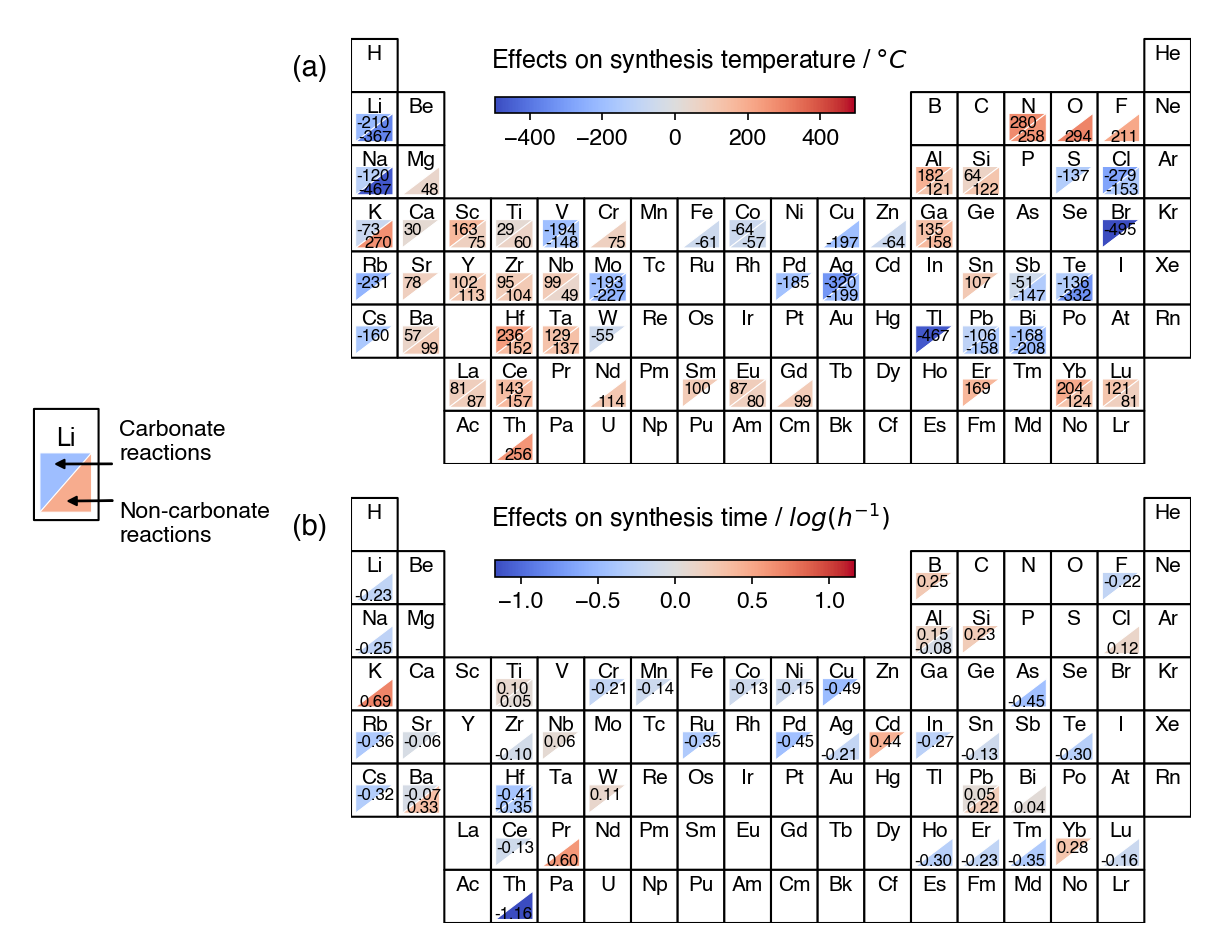

In [27]:
from s4.ml.plotting import periodic_table_heatmap_sbs
from matplotlib.colors import to_rgb
from s4.ml.plotting import generate_pt_triangulation

def draw_example(ax):
    tri_x, tri_y, tri_upper, tri_lower = generate_pt_triangulation(1, {1: 0})
    ax.pcolor(
        numpy.arange(2),
        numpy.arange(2) * 1.5,
        numpy.zeros((1, 1)),
        cmap='binary',
        # alpha=0.0,
        edgecolors="k",
        linewidths=1.,
        vmin=0,
        vmax=1,
    )
    heatmap = ax.tripcolor(
        tri_x, -tri_y, tri_upper[:1] + tri_lower[:1],
        [0.3, 0.7],
        cmap='coolwarm',
        edgecolors="white",
        linewidths=0.5,
        vmin=0,
        vmax=1,
    )
    ax.text(
        0.5,
        0.4,
        'Li',
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=12,
        color='k',
    )
    ax.set_xlim([-0.1, 2.5])
    ax.set_ylim([-0.1, 1.6])
    ax.axis("off")
    ax.invert_yaxis()
    
    ax.annotate('Carbonate\nreactions', 
                xy=(0.3, 0.75),  xycoords='data',
                xytext=(0.55, 0.86), textcoords='axes fraction', fontsize=11,
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=4),
                ha='left', verticalalignment='top',
    )
    ax.annotate('Non-carbonate\nreactions', 
                xy=(0.5, 1.25),  xycoords='data',
                xytext=(0.55, 0.21), textcoords='axes fraction', fontsize=11,
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=4),
                ha='left', verticalalignment='top',
    )

plt.rcParams["font.family"] = "Helvetica"

fig = plt.figure(figsize=(8, 6), dpi=150)

ax1_pt = fig.add_axes([0.28, 0.52, 0.70, 0.50])
ax2_pt = fig.add_axes([0.28, 0.01, 0.70, 0.50])

ax1_cbar = fig.add_axes([0.40, 0.91, 0.30, 0.018])
ax2_cbar = fig.add_axes([0.40, 0.395, 0.30, 0.018])

periodic_table_heatmap_sbs(
    {x.split('[')[0].split('_')[-1]: y
     for x, y in temp_co_fit_result_elemental.params.items() 
     if x.startswith('feature_ele')},
    {x.split('[')[0].split('_')[-1]: y
     for x, y in temp_oo_fit_result_elemental.params.items() 
     if x.startswith('feature_ele')},
    cmap='coolwarm',
    cax=ax1_cbar,
    cbar_label_size=11,
    value_format='\n%.0f',
    include_rows={1,2,3,4,5,6,8,9},
    ax=ax1_pt,
    pt_label_fontsize=10,
    pt_value_fontsize=8,
)
ax1_pt.text(3, 0.8, 'Effects on synthesis temperature / $°C$', fontsize=12)
periodic_table_heatmap_sbs(
    {x.split('[')[0].split('_')[-1]: y
     for x, y in time_co_fit_result_elemental.params.items() 
     if x.startswith('feature_ele')},
    {x.split('[')[0].split('_')[-1]: y
     for x, y in time_oo_fit_result_elemental.params.items() 
     if x.startswith('feature_ele')},
    cmap='coolwarm',
    cax=ax2_cbar,
    cbar_label_size=11,
    value_format='\n%.2f',
    include_rows={1,2,3,4,5,6,8,9},
    ax=ax2_pt,
    pt_label_fontsize=10,
    pt_value_fontsize=8,
)
ax2_pt.text(3, 0.8, 'Effects on synthesis time / $log(h^{-1})$', fontsize=12)

ax_labels = fig.add_axes([0, 0, 1, 1])
ax_labels.text(0.26, 0.96, '(a)', ha='right', va='center', fontsize=14)
ax_labels.text(0.26, 0.45, '(b)', ha='right', va='center', fontsize=14)
ax_labels.patch.set_alpha(0.0)
ax_labels.set_xlim([0, 1])
ax_labels.set_ylim([0, 1])
ax_labels.set_xticks([])
ax_labels.set_yticks([])
[v.set_visible(False) for v in ax_labels.spines.values()]

ax_legend = fig.add_axes([0.01, 0.45, 0.14, 0.14])
draw_example(ax_legend)

# plt.tight_layout()
plt.savefig('figures/Fig.Elemental-effects.pdf')
plt.show()

### (Sec Results.3): Non-linear models

#### Linear model feature learning curve

In [20]:
full_model_feature_path = pandas.read_csv('intermediate_data/Full_Feature_Path.csv', header=None, sep='\t')

(
    temp_co_feature_path,
    temp_oo_feature_path,
    time_co_feature_path,
    time_oo_feature_path,
) = full_model_feature_path[1].apply(lambda x: x.split(','))

In [21]:
temp_co_linear_train_scores, temp_co_linear_cv_scores = [], []
for i in trange(1, len(temp_co_feature_path), desc='CO/Temperature'):
    result = model_cv_analysis(
        data_frame=carb_oxi,
        features=temp_co_feature_path[:i],
        y_name='y_temperature', y_desc='Temperature',
        estimator=LinearRegression(),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=4,
    )
    temp_co_linear_train_scores.append(result['Train score'])
    temp_co_linear_cv_scores.append(result['CV score'])
    
temp_oo_linear_train_scores, temp_oo_linear_cv_scores = [], []
for i in trange(1, len(temp_oo_feature_path), desc='OO/Temperature'):
    result = model_cv_analysis(
        data_frame=oxi_oxi,
        features=temp_oo_feature_path[:i],
        y_name='y_temperature', y_desc='Temperature',
        estimator=LinearRegression(),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=4,
    )
    temp_oo_linear_train_scores.append(result['Train score'])
    temp_oo_linear_cv_scores.append(result['CV score'])

time_co_linear_train_scores, time_co_linear_cv_scores = [], []
for i in trange(1, len(time_co_feature_path), desc='CO/Time'):
    result = model_cv_analysis(
        data_frame=carb_oxi,
        features=time_co_feature_path[:i],
        y_name='y_speed', y_desc='Speed',
        estimator=LinearRegression(),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=4,
    )
    time_co_linear_train_scores.append(result['Train score'])
    time_co_linear_cv_scores.append(result['CV score'])
    
time_oo_linear_train_scores, time_oo_linear_cv_scores = [], []
for i in trange(1, len(time_oo_feature_path), desc='OO/Time'):
    result = model_cv_analysis(
        data_frame=oxi_oxi,
        features=time_oo_feature_path[:i],
        y_name='y_speed', y_desc='Speed',
        estimator=LinearRegression(),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=4,
    )
    time_oo_linear_train_scores.append(result['Train score'])
    time_oo_linear_cv_scores.append(result['CV score'])

OO/Time: 100%|██████████| 30/30 [10:24<00:00, 20.83s/it]


In [ ]:
pandas.DataFrame({
    'Train': temp_co_linear_train_scores,
    'Valid': temp_co_linear_cv_scores}).to_csv('intermediate_data/LOOCV_Linear_Temp_CO.csv')

pandas.DataFrame({
    'Train': temp_oo_linear_train_scores,
    'Valid': temp_oo_linear_cv_scores}).to_csv('intermediate_data/LOOCV_Linear_Temp_OO.csv')

pandas.DataFrame({
    'Train': time_co_linear_train_scores,
    'Valid': time_co_linear_cv_scores}).to_csv('intermediate_data/LOOCV_Linear_Time_CO.csv')

pandas.DataFrame({
    'Train': time_oo_linear_train_scores,
    'Valid': time_oo_linear_cv_scores}).to_csv('intermediate_data/LOOCV_Linear_Time_OO.csv')

#### Build XGBoost tree models

In [26]:
custom_grid_search(
    estimator_cls=XGBRegressor,
    params = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [1, 2, 3, 5, ],
#         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'booster': ['gbtree', ],#'gblinear',],# 'dart'], # dart is slow and not improving.
        'n_jobs': [1],
        'verbosity': [0]
    },
    df=carb_oxi,
    features=temp_co_feature_path,
    y_name='y_temperature',
    weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
    cv_method=5,
    do_normalization=True,
    processes=10
)

Estimator params: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.01, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -2.533
Estimator params: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.355
Estimator params: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.2, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.405
Estimator params: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.3, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.426
Estimator params: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.01, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -2.466
Estimator params: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.429
Estimator params: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.2, 'booster': 'gbtree', 'n_jobs':

{'CV results': {(100, 1, 0.01, 'gbtree', 1, 0): -2.533125603845115,
  (100, 1, 0.1, 'gbtree', 1, 0): 0.3549872010231728,
  (100, 1, 0.2, 'gbtree', 1, 0): 0.4047586553390201,
  (100, 1, 0.3, 'gbtree', 1, 0): 0.4261354898856309,
  (100, 2, 0.01, 'gbtree', 1, 0): -2.4657228740323607,
  (100, 2, 0.1, 'gbtree', 1, 0): 0.428919619634057,
  (100, 2, 0.2, 'gbtree', 1, 0): 0.46244204376032383,
  (100, 2, 0.3, 'gbtree', 1, 0): 0.4786161727055426,
  (100, 3, 0.01, 'gbtree', 1, 0): -2.4331515321719728,
  (100, 3, 0.1, 'gbtree', 1, 0): 0.45725326993305593,
  (100, 3, 0.2, 'gbtree', 1, 0): 0.4773621696680933,
  (100, 3, 0.3, 'gbtree', 1, 0): 0.46849487136303347,
  (100, 5, 0.01, 'gbtree', 1, 0): -2.401823382075089,
  (100, 5, 0.1, 'gbtree', 1, 0): 0.47869627956316363,
  (100, 5, 0.2, 'gbtree', 1, 0): 0.46768020236809704,
  (100, 5, 0.3, 'gbtree', 1, 0): 0.44917400924606254,
  (200, 1, 0.01, 'gbtree', 1, 0): -0.16233308914451183,
  (200, 1, 0.1, 'gbtree', 1, 0): 0.403798676717147,
  (200, 1, 0.2, 'gb

In [27]:
custom_grid_search(
    estimator_cls=XGBRegressor,
    params = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [1, 2, 3, 5, ],
#         'learning_rate': ,
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'booster': ['gbtree', ],#'gblinear',],# 'dart'], # dart is slow and not improving.
        'n_jobs': [1],
        'verbosity': [0]
    },
    df=oxi_oxi,
    features=temp_oo_feature_path,
    y_name='y_temperature',
    weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
    cv_method=5,
    do_normalization=True,
    processes=10
)

Estimator params: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.01, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -2.174
Estimator params: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.347
Estimator params: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.2, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.403
Estimator params: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.3, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.415
Estimator params: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.01, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -2.089
Estimator params: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.428
Estimator params: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.2, 'booster': 'gbtree', 'n_jobs':

{'CV results': {(100, 1, 0.01, 'gbtree', 1, 0): -2.173749300761897,
  (100, 1, 0.1, 'gbtree', 1, 0): 0.3474183679502675,
  (100, 1, 0.2, 'gbtree', 1, 0): 0.40271656672010747,
  (100, 1, 0.3, 'gbtree', 1, 0): 0.4148759108734873,
  (100, 2, 0.01, 'gbtree', 1, 0): -2.0891892432082306,
  (100, 2, 0.1, 'gbtree', 1, 0): 0.42795369790425386,
  (100, 2, 0.2, 'gbtree', 1, 0): 0.43770662224527135,
  (100, 2, 0.3, 'gbtree', 1, 0): 0.4310107915556417,
  (100, 3, 0.01, 'gbtree', 1, 0): -2.0388290442617025,
  (100, 3, 0.1, 'gbtree', 1, 0): 0.4375881349268609,
  (100, 3, 0.2, 'gbtree', 1, 0): 0.4419399808805833,
  (100, 3, 0.3, 'gbtree', 1, 0): 0.41632311424668944,
  (100, 5, 0.01, 'gbtree', 1, 0): -2.007037225784341,
  (100, 5, 0.1, 'gbtree', 1, 0): 0.44984782935759193,
  (100, 5, 0.2, 'gbtree', 1, 0): 0.45422179216641734,
  (100, 5, 0.3, 'gbtree', 1, 0): 0.4199900764458061,
  (200, 1, 0.01, 'gbtree', 1, 0): -0.14685020226977774,
  (200, 1, 0.1, 'gbtree', 1, 0): 0.40040805291682535,
  (200, 1, 0.2, 

The model performance seems to be insensitive to  hyper-parameters

In [31]:
temp_co_xgboost_train, temp_co_xgboost_cv_scores = [], []
for i in trange(1, len(temp_co_feature_path), desc='CO/Temperature'):
    result = model_cv_analysis(
        data_frame=carb_oxi,
        features=temp_co_feature_path[:i],
        y_name='y_temperature', y_desc='Temperature',
        estimator=XGBRegressor(
            n_estimators=300, max_depth=3, learning_rate=0.1, booster='gbtree', n_jobs=1, verbosity=0),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=16,
    )
    temp_co_xgboost_train.append(result['Train score'])
    temp_co_xgboost_cv_scores.append(result['CV score'])
    
temp_oo_xgboost_train, temp_oo_xgboost_cv_scores = [], []
for i in trange(1, len(temp_oo_feature_path), desc='OO/Temperature'):
    result = model_cv_analysis(
        data_frame=oxi_oxi,
        features=temp_oo_feature_path[:i],
        y_name='y_temperature', y_desc='Temperature',
        estimator=XGBRegressor(
            n_estimators=100, max_depth=5, learning_rate=0.2, booster='gbtree', n_jobs=1, verbosity=0),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=16,
    )
    temp_oo_xgboost_train.append(result['Train score'])
    temp_oo_xgboost_cv_scores.append(result['CV score'])
    

OO/Temperature: 100%|██████████| 40/40 [2:14:16<00:00, 201.41s/it]


Time models

In [30]:
custom_grid_search(
    estimator_cls=XGBRegressor,
    params = {
        'n_estimators': [10, 20, 50, 100, 200],
        'max_depth': [1, 2, 3, 5],
#         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'learning_rate': [0.05, 0.1, 0.2, 0.3],
        'booster': ['gbtree'],#'gblinear',],# 'dart'], # dart is slow and not improving.
        'n_jobs': [1],
        'verbosity': [0]
    },
    df=carb_oxi,
    features=time_co_feature_path,#time_linear_co_features_di_sorted,
    y_name='y_speed',
    weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
    cv_method=10,
    do_normalization=True,
    processes=10
)

Estimator params: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.05, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -3.775
Estimator params: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.1, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -1.237
Estimator params: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.2, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -0.020
Estimator params: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.3, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.129
Estimator params: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.05, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -3.755
Estimator params: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.1, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -1.201
Estimator params: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.2, 'booster': 'gbtree', 'n_jobs': 1, 

{'CV results': {(10, 1, 0.05, 'gbtree', 1, 0): -3.7746294782093157,
  (10, 1, 0.1, 'gbtree', 1, 0): -1.2373903622459306,
  (10, 1, 0.2, 'gbtree', 1, 0): -0.01950491850511371,
  (10, 1, 0.3, 'gbtree', 1, 0): 0.1288565659803984,
  (10, 2, 0.05, 'gbtree', 1, 0): -3.755447888707729,
  (10, 2, 0.1, 'gbtree', 1, 0): -1.2009309316034558,
  (10, 2, 0.2, 'gbtree', 1, 0): 0.017878113016567276,
  (10, 2, 0.3, 'gbtree', 1, 0): 0.14883783722364385,
  (10, 3, 0.05, 'gbtree', 1, 0): -3.7380623354505715,
  (10, 3, 0.1, 'gbtree', 1, 0): -1.1868272959904562,
  (10, 3, 0.2, 'gbtree', 1, 0): 0.03480771029409868,
  (10, 3, 0.3, 'gbtree', 1, 0): 0.17632859818831847,
  (10, 5, 0.05, 'gbtree', 1, 0): -3.724794817159353,
  (10, 5, 0.1, 'gbtree', 1, 0): -1.1756301860070613,
  (10, 5, 0.2, 'gbtree', 1, 0): 0.06453340848519129,
  (10, 5, 0.3, 'gbtree', 1, 0): 0.19695555720833524,
  (20, 1, 0.05, 'gbtree', 1, 0): -1.3093659712194183,
  (20, 1, 0.1, 'gbtree', 1, 0): -0.054999179438534274,
  (20, 1, 0.2, 'gbtree', 1

In [29]:
custom_grid_search(
    estimator_cls=XGBRegressor,
    params = {
        'n_estimators': [10, 20, 50, 100, 200],
        'max_depth': [1, 2, 3, 5],
#         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'learning_rate': [0.05, 0.1, 0.2, 0.3],
        'booster': ['gbtree'],#'gblinear',],# 'dart'], # dart is slow and not improving.
        'n_jobs': [1],
        'verbosity': [0]
    },
    df=oxi_oxi,
    features=time_oo_feature_path,#time_linear_co_features_di_sorted,
    y_name='y_speed',
    weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
    cv_method=10,
    do_normalization=True,
    processes=10
)

Estimator params: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.05, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -3.426
Estimator params: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.1, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -1.113
Estimator params: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.2, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -0.004
Estimator params: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.3, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: 0.132
Estimator params: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.05, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -3.420
Estimator params: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.1, 'booster': 'gbtree', 'n_jobs': 1, 'verbosity': 0} ==> CV score: -1.093
Estimator params: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.2, 'booster': 'gbtree', 'n_jobs': 1, 

{'CV results': {(10, 1, 0.05, 'gbtree', 1, 0): -3.4256577562244965,
  (10, 1, 0.1, 'gbtree', 1, 0): -1.1127231381618459,
  (10, 1, 0.2, 'gbtree', 1, 0): -0.003963355844751826,
  (10, 1, 0.3, 'gbtree', 1, 0): 0.1324235749153413,
  (10, 2, 0.05, 'gbtree', 1, 0): -3.4196178362236473,
  (10, 2, 0.1, 'gbtree', 1, 0): -1.092662280376521,
  (10, 2, 0.2, 'gbtree', 1, 0): 0.03308667133945409,
  (10, 2, 0.3, 'gbtree', 1, 0): 0.1668090829204376,
  (10, 3, 0.05, 'gbtree', 1, 0): -3.399303523323386,
  (10, 3, 0.1, 'gbtree', 1, 0): -1.0632323351447792,
  (10, 3, 0.2, 'gbtree', 1, 0): 0.06325909737983737,
  (10, 3, 0.3, 'gbtree', 1, 0): 0.19989850218206828,
  (10, 5, 0.05, 'gbtree', 1, 0): -3.384099295592118,
  (10, 5, 0.1, 'gbtree', 1, 0): -1.0442592825977761,
  (10, 5, 0.2, 'gbtree', 1, 0): 0.08558231951541073,
  (10, 5, 0.3, 'gbtree', 1, 0): 0.2170961991282887,
  (20, 1, 0.05, 'gbtree', 1, 0): -1.1797901000724242,
  (20, 1, 0.1, 'gbtree', 1, 0): -0.03656048462865402,
  (20, 1, 0.2, 'gbtree', 1, 0)

In [38]:
time_co_xgboost_train, time_co_xgboost_train_cv = [], []
for i in trange(1, len(time_co_feature_path), desc='CO/Time'):
    result = model_cv_analysis(
        data_frame=carb_oxi,
        features=time_co_feature_path[:i],
        y_name='y_speed', y_desc='Speed',
        estimator=XGBRegressor(
            n_estimators=100, max_depth=5, learning_rate=0.1, booster='gbtree', n_jobs=1, verbosity=0),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=16,
    )
    time_co_xgboost_train.append(result['Train score'])
    time_co_xgboost_train_cv.append(result['CV score'])
    
time_oo_xgboost_train, time_oo_xgboost_train_cv = [], []
for i in trange(1, len(time_oo_feature_path), desc='OO/Time'):
    result = model_cv_analysis(
        data_frame=oxi_oxi,
        features=time_oo_feature_path[:i],
        y_name='y_speed', y_desc='Speed',
        estimator=XGBRegressor(
            n_estimators=100, max_depth=5, learning_rate=0.05, booster='gbtree', n_jobs=1, verbosity=0),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=16,
    )
    time_oo_xgboost_train.append(result['Train score'])
    time_oo_xgboost_train_cv.append(result['CV score'])

OO/Time: 100%|██████████| 30/30 [1:30:35<00:00, 181.18s/it]


In [40]:
pandas.DataFrame({
    'Train': temp_co_xgboost_train,
    'Valid': temp_co_xgboost_cv_scores}).to_csv('intermediate_data/LOOCV_XGBoost_Temp_CO.csv')

pandas.DataFrame({
    'Train': temp_oo_xgboost_train,
    'Valid': temp_oo_xgboost_cv_scores}).to_csv('intermediate_data/LOOCV_XGBoost_Temp_OO.csv')

pandas.DataFrame({
    'Train': time_co_xgboost_train,
    'Valid': time_co_xgboost_train_cv}).to_csv('intermediate_data/LOOCV_XGBoost_Time_CO.csv')

pandas.DataFrame({
    'Train': time_oo_xgboost_train,
    'Valid': time_oo_xgboost_train_cv}).to_csv('intermediate_data/LOOCV_XGBoost_Time_OO.csv')

#### Make plots (Fig. 4)

In [181]:
cv_linear_temp_co = pandas.read_csv('intermediate_data/LOOCV_Linear_Temp_CO.csv')
cv_linear_temp_oo = pandas.read_csv('intermediate_data/LOOCV_Linear_Temp_OO.csv')
cv_linear_time_co = pandas.read_csv('intermediate_data/LOOCV_Linear_Time_CO.csv')
cv_linear_time_oo = pandas.read_csv('intermediate_data/LOOCV_Linear_Time_OO.csv')

cv_xgboost_temp_co = pandas.read_csv('intermediate_data/LOOCV_XGBoost_Temp_CO.csv')
cv_xgboost_temp_oo = pandas.read_csv('intermediate_data/LOOCV_XGBoost_Temp_OO.csv')
cv_xgboost_time_co = pandas.read_csv('intermediate_data/LOOCV_XGBoost_Time_CO.csv')
cv_xgboost_time_oo = pandas.read_csv('intermediate_data/LOOCV_XGBoost_Time_OO.csv')

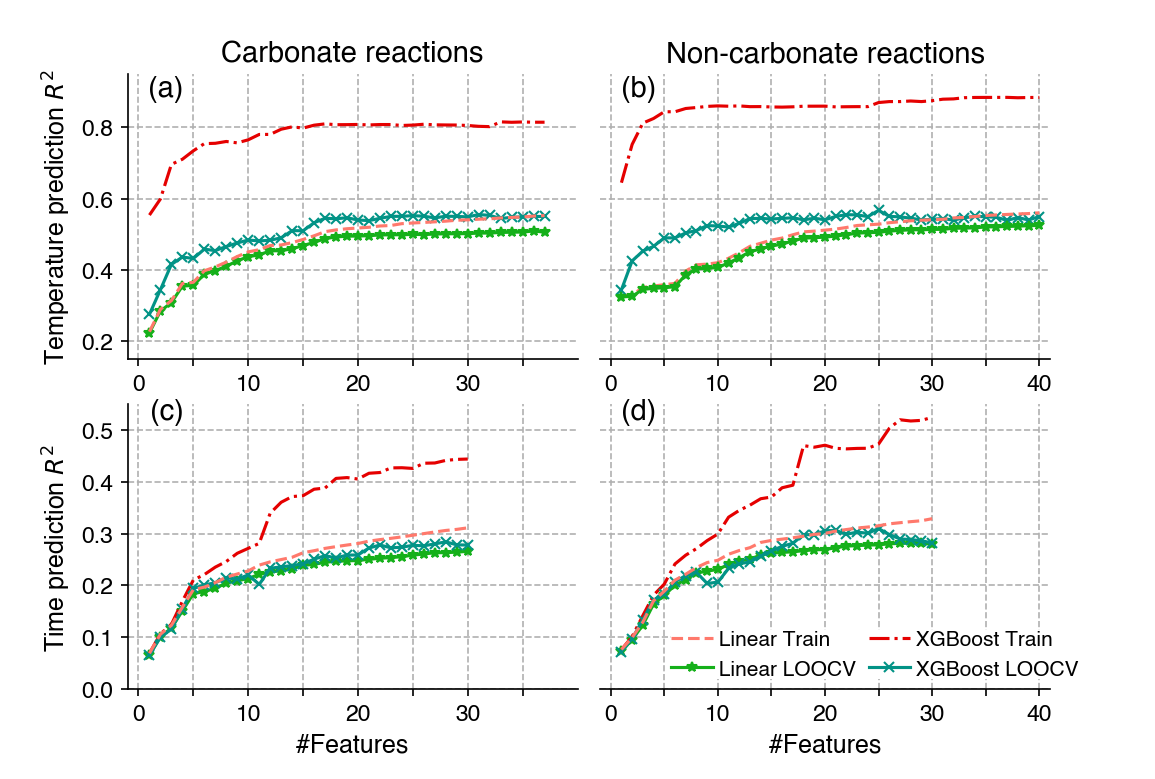

In [193]:
fig = plt.figure(figsize=(7.5, 5), dpi=150)
legend_format = {'fontsize': 10, 'fancybox': False, 'frameon': True, 'ncol': 2,
                 'facecolor': 'white', 'edgecolor': 'none', 'framealpha': 1.0,
                 'columnspacing': 0.6, 'bbox_to_anchor': [1.1, 0.0],
                 'borderpad': 0., 'handletextpad': 0., 'loc': 'lower right'}

ax1 = fig.add_axes([0.1, 0.54, 0.40, 0.38])
ax2 = fig.add_axes([0.52, 0.54, 0.40, 0.38])
ax3 = fig.add_axes([0.1, 0.1, 0.40, 0.38])
ax4 = fig.add_axes([0.52, 0.1, 0.40, 0.38])

ax1.plot(list(range(1, len(cv_linear_temp_co)+1)), cv_linear_temp_co['Train'], zorder=100, color='xkcd:salmon', linestyle='--', label='Linear Train')
ax1.plot(list(range(1, len(cv_linear_temp_co)+1)), cv_linear_temp_co['Valid'], '*-', color='xkcd:green', markersize=5,  label='Linear LOOCV')
ax1.plot(list(range(1, len(cv_xgboost_temp_co)+1)), cv_xgboost_temp_co['Train'], linestyle='dashdot', color='xkcd:red', label='XGBoost Train')
ax1.plot(list(range(1, len(cv_xgboost_temp_co)+1)), cv_xgboost_temp_co['Valid'], 'x-', color='xkcd:teal', markersize=5, label='XGBoost LOOCV')
# ax1.set_xlabel('#Features', fontsize=10)
ax1.set_ylabel('Temperature prediction $R^2$', fontsize=12)
# ax1.legend(**legend_format)
ax1.set_xticks(list(range(0, 40, 5)))
ax1.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 40, 5)], fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.grid('on', linestyle='--')
ax1.set_title('Carbonate reactions', fontsize=14)
ax1.set_xlim([-1, 40])
ax1.set_ylim([0.15, 0.95])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.plot(list(range(1, len(cv_linear_temp_oo)+1)), cv_linear_temp_oo['Valid'], '*-', zorder=100, color='xkcd:green', markersize=5, label='Linear LOOCV')
ax2.plot(list(range(1, len(cv_xgboost_temp_oo)+1)), cv_xgboost_temp_oo['Train'], linestyle='dashdot', color='xkcd:red', label='XGBoost Train')
ax2.plot(list(range(1, len(cv_xgboost_temp_oo)+1)), cv_xgboost_temp_oo['Valid'], 'x-', color='xkcd:teal', markersize=5, label='XGBoost LOOCV')
ax2.plot(list(range(1, len(cv_linear_temp_oo)+1)), cv_linear_temp_oo['Train'], color='xkcd:salmon', linestyle='--', label='Linear Train')
# ax2.set_xlabel('#Features', fontsize=10)
# ax2.set_ylabel('Temperature prediction R2', fontsize=10)
# ax2.legend(**legend_format)
ax2.set_xticks(list(range(0, 41, 5)))
ax2.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 41, 5)], fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='y', which='both',length=0)
ax2.grid('on', linestyle='--')
ax2.set_yticklabels([])
ax2.set_title('Non-carbonate reactions', fontsize=14)
ax2.set_xlim([-1, 41])
ax2.set_ylim([0.15, 0.95])
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3.plot(list(range(1, len(cv_linear_time_co)+1)), cv_linear_time_co['Train'], zorder=100, color='xkcd:salmon', linestyle='--', label='Linear Train')
ax3.plot(list(range(1, len(cv_linear_time_co)+1)), cv_linear_time_co['Valid'], '*-', color='xkcd:green', markersize=5, label='Linear LOOCV')
ax3.plot(list(range(1, len(cv_xgboost_time_co)+1)), cv_xgboost_time_co['Train'], linestyle='dashdot', color='xkcd:red', label='XGBoost Train')
ax3.plot(list(range(1, len(cv_xgboost_time_co)+1)), cv_xgboost_time_co['Valid'], 'x-', color='xkcd:teal', markersize=5, label='XGBoost LOOCV')
ax3.set_xlabel('#Features', fontsize=12)
ax3.set_ylabel('Time prediction $R^2$', fontsize=12)
ax3.set_xticks(list(range(0, 40, 5)))
ax3.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 40, 5)], fontsize=12)
# ax3.legend(**legend_format)
ax3.tick_params(axis='both', which='major', labelsize=11)
ax3.grid('on', linestyle='--')
ax3.set_xlim([-1, 40])
ax3.set_ylim([0.0, 0.55])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4.plot(list(range(1, len(cv_linear_time_oo)+1)), cv_linear_time_oo['Train'], zorder=100, color='xkcd:salmon', linestyle='--', label=' Linear Train')
ax4.plot(list(range(1, len(cv_linear_time_oo)+1)), cv_linear_time_oo['Valid'], '*-', color='xkcd:green', markersize=5, label=' Linear LOOCV')
ax4.plot(list(range(1, len(cv_xgboost_time_oo)+1)), cv_xgboost_time_oo['Train'], linestyle='dashdot', color='xkcd:red', label=' XGBoost Train')
ax4.plot(list(range(1, len(cv_xgboost_time_oo)+1)), cv_xgboost_time_oo['Valid'], 'x-', color='xkcd:teal', markersize=5, label=' XGBoost LOOCV ')
ax4.set_xlabel('#Features', fontsize=12)
# ax4.set_ylabel('Time prediction R2', fontsize=10)
ax4.set_xticks(list(range(0, 41, 5)))
ax4.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 41, 5)], fontsize=12)
ax4.legend(**legend_format)
ax4.tick_params(axis='both', which='major', labelsize=11)
ax4.tick_params(axis='y', which='both',length=0)
ax4.grid('on', linestyle='--')
ax4.set_yticklabels([])
ax4.set_xlim([-1, 41])
ax4.set_ylim([0.0, 0.55])
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax_labels = fig.add_axes([0, 0, 1, 1])
ax_labels.text(0.15, 0.9, '(a)', ha='right', va='center', fontsize=14)
ax_labels.text(0.57, 0.9, '(b)', ha='right', va='center', fontsize=14)
ax_labels.text(0.15, 0.47, '(c)', ha='right', va='center', fontsize=14)
ax_labels.text(0.57, 0.47, '(d)', ha='right', va='center', fontsize=14)
ax_labels.patch.set_alpha(0.0)
ax_labels.set_xlim([0, 1])
ax_labels.set_ylim([0, 1])
ax_labels.set_xticks([])
ax_labels.set_yticks([])
[v.set_visible(False) for v in ax_labels.spines.values()]

# plt.tight_layout()
plt.savefig('figures/Fig.4.Nonlinear.pdf')
plt.show()

#### Build KRR models

In [8]:
custom_grid_search(
    estimator_cls=KernelRidge,
    params = {
        'alpha': [1e-4, 2e-4, 4e-4, 6e-4, 8e-4, 1e-3],
        'kernel': [ 'laplacian']
    },
    df=carb_oxi,
    features=feat_temp_pred,
    y_name='y_temperature',
    weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
    cv_method='loo',
    do_normalization=True,
    processes=8
)

Estimator params: {'alpha': 0.0001, 'kernel': 'laplacian'} ==> CV score: 0.447
Estimator params: {'alpha': 0.0002, 'kernel': 'laplacian'} ==> CV score: 0.452
Estimator params: {'alpha': 0.0004, 'kernel': 'laplacian'} ==> CV score: 0.449
Estimator params: {'alpha': 0.0006, 'kernel': 'laplacian'} ==> CV score: 0.444
Estimator params: {'alpha': 0.0008, 'kernel': 'laplacian'} ==> CV score: 0.439
Estimator params: {'alpha': 0.001, 'kernel': 'laplacian'} ==> CV score: 0.435


{'CV results': {(0.0001, 'laplacian'): 0.4465933199904977,
  (0.0002, 'laplacian'): 0.4520094745172273,
  (0.0004, 'laplacian'): 0.44895953043505665,
  (0.0006, 'laplacian'): 0.4439470441725518,
  (0.0008, 'laplacian'): 0.4391187693946237,
  (0.001, 'laplacian'): 0.4346782655005492},
 'Best param': (0.0002, 'laplacian'),
 'Best CV result': 0.4520094745172273}

In [6]:
custom_grid_search(
    estimator_cls=KernelRidge,
    params = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.],
        'kernel': ['rbf', 'linear', 'poly', 'laplacian']
    },
    df=carb_oxi,
    features=feat_temp_pred,
    y_name='y_temperature',
    weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
    cv_method='loo',
    do_normalization=True,
    processes=8
)

Estimator params: {'alpha': 0.0001, 'kernel': 'rbf'} ==> CV score: 0.206
Estimator params: {'alpha': 0.0001, 'kernel': 'linear'} ==> CV score: 0.133
Estimator params: {'alpha': 0.0001, 'kernel': 'poly'} ==> CV score: 0.209
Estimator params: {'alpha': 0.0001, 'kernel': 'laplacian'} ==> CV score: 0.447
Estimator params: {'alpha': 0.001, 'kernel': 'rbf'} ==> CV score: 0.214
Estimator params: {'alpha': 0.001, 'kernel': 'linear'} ==> CV score: 0.157
Estimator params: {'alpha': 0.001, 'kernel': 'poly'} ==> CV score: 0.209
Estimator params: {'alpha': 0.001, 'kernel': 'laplacian'} ==> CV score: 0.435
Estimator params: {'alpha': 0.01, 'kernel': 'rbf'} ==> CV score: 0.227
Estimator params: {'alpha': 0.01, 'kernel': 'linear'} ==> CV score: 0.193
Estimator params: {'alpha': 0.01, 'kernel': 'poly'} ==> CV score: 0.233
Estimator params: {'alpha': 0.01, 'kernel': 'laplacian'} ==> CV score: 0.360
Estimator params: {'alpha': 0.1, 'kernel': 'rbf'} ==> CV score: 0.093
Estimator params: {'alpha': 0.1, 'ke

{'CV results': {(0.0001, 'rbf'): 0.20567041770164451,
  (0.0001, 'linear'): 0.13305269782526175,
  (0.0001, 'poly'): 0.20852831100841807,
  (0.0001, 'laplacian'): 0.4465933199904977,
  (0.001, 'rbf'): 0.21381592015444317,
  (0.001, 'linear'): 0.15679678545135267,
  (0.001, 'poly'): 0.20900918487662024,
  (0.001, 'laplacian'): 0.4346782655005492,
  (0.01, 'rbf'): 0.22664347416114738,
  (0.01, 'linear'): 0.1934082031505635,
  (0.01, 'poly'): 0.23285398601509677,
  (0.01, 'laplacian'): 0.3597262903774191,
  (0.1, 'rbf'): 0.09327647224064817,
  (0.1, 'linear'): 0.20236847479683318,
  (0.1, 'poly'): 0.12290431368234633,
  (0.1, 'laplacian'): 0.2480424725974245,
  (1.0, 'rbf'): 0.005652649085961525,
  (1.0, 'linear'): 0.07760755834518152,
  (1.0, 'poly'): 0.013865276201898591,
  (1.0, 'laplacian'): 0.06581277693893028},
 'Best param': (0.0001, 'laplacian'),
 'Best CV result': 0.4465933199904977}

In [ ]:
custom_grid_search(
    estimator_cls=KernelRidge,
    params = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.],
        'kernel': ['rbf', 'linear', 'poly', 'laplacian']
    },
    df=oxides_multistep,
    features=all_possible_features_temperature,
    y_name='y_temperature',
    weights=1.0 / (1 + numpy.log(oxides_multistep['meta_precursor_freq'].values)) ** 2,
    cv_method='loo',
    processes=8
)

### (Sec Results.4): PCD prediction

#### Load data

In [4]:
with open('intermediate_data/PCD_TrainingData.pypickle', 'rb') as f:
    pcd_data = pickle.load(f)

pcd_data = pcd_data.rename(axis=1, mapper=lambda x: x.replace('3.15', '3_15'))

scale_down = [
    'feature_exp_min_mp',
    'feature_exp_max_mp',
    'feature_exp_mean_mp',
    'feature_exp_div_mp',
    'feature_thermo_lb_temp',
    'feature_thermo_ub_temp',
]
for feat in scale_down:
    pcd_data[feat] = pcd_data[feat] / 1000
    
scale_up = [
    'feature_thermo_total_ddf',
    'feature_thermo_first_ddf',
]
for feat in scale_up:
    pcd_data[feat] = pcd_data[feat] * 1000

pcd_data = pcd_data.drop_duplicates(subset=('meta_k', 'meta_i')).set_index(keys=['meta_k', 'meta_i'])

pcd_carb_oxi = pcd_data.query('feature_syn_n_carbonates>0').dropna()
pcd_oxi_oxi = pcd_data.query('feature_syn_n_carbonates==0').dropna()

print('==== Outlier detection for carbonate/oxide reactions ====')
for name in pcd_carb_oxi.columns:
    if not name.startswith('feature_') or pcd_carb_oxi[name].dtype.kind != 'f':
        continue
    pcd_carb_oxi = simple_outlier_detection(pcd_carb_oxi, name)
    
print('==== Outlier detection for oxide/oxide reactions ====')
for name in pcd_oxi_oxi.columns:
    if not name.startswith('feature_') or pcd_oxi_oxi[name].dtype.kind != 'f':
        continue
    pcd_oxi_oxi = simple_outlier_detection(pcd_oxi_oxi, name)

print(f'Precursor type: carbonate + oxide, there are {len(carb_oxi)} PCD entries')
print(f'Precursor type: oxide + oxide, there are {len(oxi_oxi)} PCD entries')

==== Outlier detection for carbonate/oxide reactions ====
Dropped 54 rows for column feature_thermo_1073_15_total_df
Dropped 1 rows for column feature_thermo_1073_15_first_df
Dropped 9 rows for column feature_thermo_1073_15_last_df
Dropped 108 rows for column feature_thermo_1073_15_first_df_frac
Dropped 5 rows for column feature_thermo_1073_15_last_df_frac
Dropped 5 rows for column feature_thermo_1173_15_total_df
Dropped 5 rows for column feature_thermo_1173_15_first_df_frac
Dropped 2 rows for column feature_thermo_1173_15_last_df_frac
Dropped 3 rows for column feature_thermo_1273_15_total_df
Dropped 1 rows for column feature_thermo_1273_15_first_df_frac
Dropped 1 rows for column feature_thermo_1373_15_total_df
Dropped 3 rows for column feature_thermo_1373_15_first_df_frac
Dropped 1 rows for column feature_thermo_1473_15_last_df_frac
Dropped 1 rows for column feature_thermo_1573_15_total_df
Dropped 2 rows for column feature_thermo_1573_15_first_df_frac
Dropped 3 rows for column feature

In [6]:
pcd_carb_oxi

,,meta_doi,meta_precursors,meta_text,y_speed,y_temperature,feature_ele_Li,feature_ele_Be,feature_ele_B,feature_ele_C,feature_ele_N,...,feature_max_p_h_300K,feature_diff_p_h_300K,feature_avg_dgf_300K,feature_min_dgf_300K,feature_max_dgf_300K,feature_diff_dgf_300K,feature_syn_n_precursors,feature_syn_n_carbonates,feature_syn_n_target_mixture,meta_precursor_freq
meta_k,meta_i,,,,,,,,,,,,,,,,,,,,,
920,0,n/a,"(PbO, SrCO3)",,-99.954243,900,False,False,False,False,False,...,-2.268810,10.360886,-6.876301,-11.796337,-1.956264,9.840073,2,1,1,1
776,0,n/a,"(CaCO3, RuO2)",,-99.954243,1200,False,False,False,False,False,...,-3.160213,9.355704,-7.151606,-11.687644,-2.615568,9.072076,2,1,1,21
150,0,n/a,"(Ga2O3, K2CO3)",,-99.954243,850,False,False,False,False,False,...,-11.285897,0.632682,-10.684878,-11.028038,-10.341719,0.686319,2,1,1,1
798,0,n/a,"(CaCO3, SiO2)",,-99.954243,1500,False,False,False,False,False,...,-9.440361,3.075556,-10.281446,-11.687644,-8.875248,2.812396,2,1,1,29
622,0,n/a,"(CaCO3, Cr2O3, La2O3)",,-99.954243,1350,False,False,False,False,False,...,-11.818743,6.769366,-13.444583,-17.675941,-10.970164,6.705777,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96484,0,n/a,"(CaCO3, Co3O4)",,-99.954243,1000,False,False,False,False,False,...,-9.520376,2.995542,-9.997533,-11.687644,-8.307422,3.380222,2,1,1,10
96669,0,n/a,"(RuO2, SrCO3, TiO2)",,-99.954243,1200,False,False,False,False,False,...,-3.160213,9.469483,-7.873918,-11.796337,-2.615568,9.180768,3,1,1,2
96377,0,n/a,"(Bi2O3, Fe2O3, K2CO3, Nb2O5)",,-99.954243,800,False,False,False,False,False,...,-5.945628,13.739130,-10.530031,-18.293843,-5.109655,13.184188,4,1,3,11


#### Learning curve - linear

In [111]:
full_model_feature_path = pandas.read_csv('intermediate_data/Full_Feature_Path.csv', header=None, sep='\t')

(
    temp_co_feature_path,
    temp_oo_feature_path,
    time_co_feature_path,
    time_oo_feature_path,
) = full_model_feature_path[1].apply(lambda x: x.split(','))

In [112]:
pcd_temp_co_linear_train, pcd_temp_co_linear_cv = [], []
for i in trange(1, len(temp_co_feature_path), desc='CO/Temperature'):
    result = model_cv_analysis(
        data_frame=pcd_carb_oxi,
        features=temp_co_feature_path[:i],
        y_name='y_temperature', y_desc='Temperature',
        estimator=LinearRegression(),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(pcd_carb_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=4,
    )
    pcd_temp_co_linear_train.append(result['Train score'])
    pcd_temp_co_linear_cv.append(result['CV score'])
    
pcd_temp_oo_linear_train, pcd_temp_oo_linear_cv = [], []
for i in trange(1, len(temp_oo_feature_path), desc='OO/Temperature'):
    result = model_cv_analysis(
        data_frame=pcd_oxi_oxi,
        features=temp_oo_feature_path[:i],
        y_name='y_temperature', y_desc='Temperature',
        estimator=LinearRegression(),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(pcd_oxi_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=4,
    )
    pcd_temp_oo_linear_train.append(result['Train score'])
    pcd_temp_oo_linear_cv.append(result['CV score'])

OO/Temperature: 100%|██████████| 40/40 [13:36<00:00, 20.42s/it]


In [125]:
def out_of_sample_prediction(train_df, train_features, oss_df, y_name, use_wls=False):
    if use_wls:
        train_fit_result = sm.wls(
            formula=f'{y_name} ~ {"+".join(train_features)}',
            data=train_df, 
            weights=1.0/(1+numpy.log(train_df['meta_precursor_freq'].values))**2
        ).fit()
        weights_fn = lambda x: 1.0/(1+numpy.log(x['meta_precursor_freq'].values))**2
    else:
        train_fit_result = sm.ols(
            formula=f'{y_name} ~ {"+".join(train_features)}',
            data=train_df, 
        ).fit()
        weights_fn = lambda x: None

#     print('Train fit R2/AdjR2: %.3f/%.3f' % (train_fit_result.rsquared, train_fit_result.rsquared_adj))
#     print('OSS fit R2/AdjR2: %.3f/%.3f' % (oss_fit_result.rsquared, oss_fit_result.rsquared_adj))

    y_pred = train_fit_result.predict(oss_df)
    y_true = oss_df[y_name]
    pr2 = r2_score(y_true, y_pred, sample_weight=weights_fn(oss_df))
#     print('Pseudo R2', pr2)
    
    return {
#         'OSS Fit': oss_fit_result,
        'Train Fit': train_fit_result,
#         'Fit Result Table': fit_results,
        'Pseudo R2': pr2
    }

pcd_oos_temp_co_linear_cv = []
for i in trange(1, len(temp_co_feature_path), desc='CO/Temperature'):
    pcd_oos_temp_co_linear_cv.append(out_of_sample_prediction(
        train_df=carb_oxi,
        train_features=temp_co_feature_path[:i],
        oss_df=pcd_carb_oxi,
        y_name='y_temperature', 
        use_wls=True
    )['Pseudo R2'])
    
pcd_oos_temp_oo_linear_cv = []
for i in trange(1, len(temp_oo_feature_path), desc='OO/Temperature'):
    pcd_oos_temp_oo_linear_cv.append(out_of_sample_prediction(
        train_df=oxi_oxi,
        train_features=temp_oo_feature_path[:i],
        oss_df=pcd_oxi_oxi,
        y_name='y_temperature', 
        use_wls=True
    )['Pseudo R2'])

OO/Temperature: 100%|██████████| 40/40 [00:05<00:00,  6.75it/s]


In [ ]:
pandas.DataFrame({
    'Train': pcd_temp_co_linear_train,
    'Valid': pcd_temp_co_linear_cv}).to_csv('intermediate_data/PCD_ProperTrained_Temp_CO.csv')

pandas.DataFrame({
    'Train': pcd_temp_oo_linear_train,
    'Valid': pcd_temp_oo_linear_cv}).to_csv('intermediate_data/PCD_ProperTrained_Temp_OO.csv')

pandas.DataFrame({
    'Valid': pcd_oos_temp_co_linear_cv}).to_csv('intermediate_data/PCD_OOS_Temp_CO.csv')
pandas.DataFrame({
    'Valid': pcd_oos_temp_oo_linear_cv}).to_csv('intermediate_data/PCD_OOS_Temp_OO.csv')

#### Learning curve - XGBoost

In [146]:
pcd_temp_co_xgboost_train, pcd_temp_co_xgboost_cv_scores = [], []
for i in trange(1, len(temp_co_feature_path), desc='CO/Temperature'):
    result = model_cv_analysis(
        data_frame=pcd_carb_oxi,
        features=temp_co_feature_path[:i],
        y_name='y_temperature', y_desc='Temperature',
        estimator=XGBRegressor(
            n_estimators=300, max_depth=3, learning_rate=0.1, booster='gbtree', n_jobs=1, verbosity=0),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(pcd_carb_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=16,
    )
    pcd_temp_co_xgboost_train.append(result['Train score'])
    pcd_temp_co_xgboost_cv_scores.append(result['CV score'])
    
pcd_temp_oo_xgboost_train, pcd_temp_oo_xgboost_cv_scores = [], []
for i in trange(1, len(temp_oo_feature_path), desc='OO/Temperature'):
    result = model_cv_analysis(
        data_frame=pcd_oxi_oxi,
        features=temp_oo_feature_path[:i],
        y_name='y_temperature', y_desc='Temperature',
        estimator=XGBRegressor(
            n_estimators=100, max_depth=5, learning_rate=0.2, booster='gbtree', n_jobs=1, verbosity=0),
        cv_method='loo',
        weights=1.0 / (1 + numpy.log(pcd_oxi_oxi['meta_precursor_freq'].values)) ** 2,
        do_plot=False,
        display_pbar=False,
        processes=16,
    )
    pcd_temp_oo_xgboost_train.append(result['Train score'])
    pcd_temp_oo_xgboost_cv_scores.append(result['CV score'])

OO/Temperature: 100%|██████████| 40/40 [2:18:05<00:00, 207.14s/it]


In [159]:
def out_of_sample_prediction(train_df, train_features, estimator, oss_df, y_name, use_wls=False):
    estimator.fit(
        train_df[train_features], train_df[y_name], 
        sample_weight=1.0/(1+numpy.log(train_df['meta_precursor_freq'].values))**2
    )

    y_pred = estimator.predict(oss_df[train_features])
    y_true = oss_df[y_name]
    pr2 = r2_score(y_true, y_pred, 
                   sample_weight=1.0/(1+numpy.log(oss_df['meta_precursor_freq'].values))**2)
    
    return {
        'Pseudo R2': pr2
    }

pcd_oos_temp_co_xgboost_cv = []
for i in trange(1, len(temp_co_feature_path), desc='CO/Temperature'):
    pcd_oos_temp_co_xgboost_cv.append(out_of_sample_prediction(
        train_df=carb_oxi,
        train_features=temp_co_feature_path[:i],
        estimator=XGBRegressor(
            n_estimators=300, max_depth=3, learning_rate=0.1, booster='gbtree', n_jobs=1, verbosity=0),
        oss_df=pcd_carb_oxi,
        y_name='y_temperature', 
        use_wls=True
    )['Pseudo R2'])
    
pcd_oos_temp_oo_xgboost_cv = []
for i in trange(1, len(temp_oo_feature_path), desc='OO/Temperature'):
    pcd_oos_temp_oo_xgboost_cv.append(out_of_sample_prediction(
        train_df=oxi_oxi,
        train_features=temp_oo_feature_path[:i],
        estimator=XGBRegressor(
            n_estimators=100, max_depth=5, learning_rate=0.2, booster='gbtree', n_jobs=1, verbosity=0),
        oss_df=pcd_oxi_oxi,
        y_name='y_temperature', 
        use_wls=True
    )['Pseudo R2'])

OO/Temperature: 100%|██████████| 40/40 [00:18<00:00,  2.12it/s]


In [160]:
pandas.DataFrame({
    'Train': pcd_temp_co_xgboost_train,
    'Valid': pcd_temp_co_xgboost_cv_scores}).to_csv('intermediate_data/PCD_XGBoost_InSample_Temp_CO.csv')

pandas.DataFrame({
    'Train': pcd_temp_oo_xgboost_train,
    'Valid': pcd_temp_oo_xgboost_cv_scores}).to_csv('intermediate_data/PCD_XGBoost_InSample_Temp_OO.csv')

pandas.DataFrame({
    'Valid': pcd_oos_temp_co_xgboost_cv}).to_csv('intermediate_data/PCD_XGBoost_OOS_Temp_CO.csv')
pandas.DataFrame({
    'Valid': pcd_oos_temp_oo_xgboost_cv}).to_csv('intermediate_data/PCD_XGBoost_OOS_Temp_OO.csv')

#### Make plots (Fig. 5)

In [7]:
pcd_linear_temp_co_train = pandas.read_csv('intermediate_data/PCD_ProperTrained_Temp_CO.csv')
pcd_linear_temp_oo_train = pandas.read_csv('intermediate_data/PCD_ProperTrained_Temp_OO.csv')

pcd_xgboost_temp_co_train = pandas.read_csv('intermediate_data/PCD_XGBoost_InSample_Temp_CO.csv')
pcd_xgboost_temp_oo_train = pandas.read_csv('intermediate_data/PCD_XGBoost_InSample_Temp_OO.csv')

pcd_linear_temp_co_oos = pandas.read_csv('intermediate_data/PCD_OOS_Temp_CO.csv')
pcd_linear_temp_oo_oos = pandas.read_csv('intermediate_data/PCD_OOS_Temp_OO.csv')

pcd_xgboost_temp_co_oos = pandas.read_csv('intermediate_data/PCD_XGBoost_OOS_Temp_CO.csv')
pcd_xgboost_temp_oo_oos = pandas.read_csv('intermediate_data/PCD_XGBoost_OOS_Temp_OO.csv')

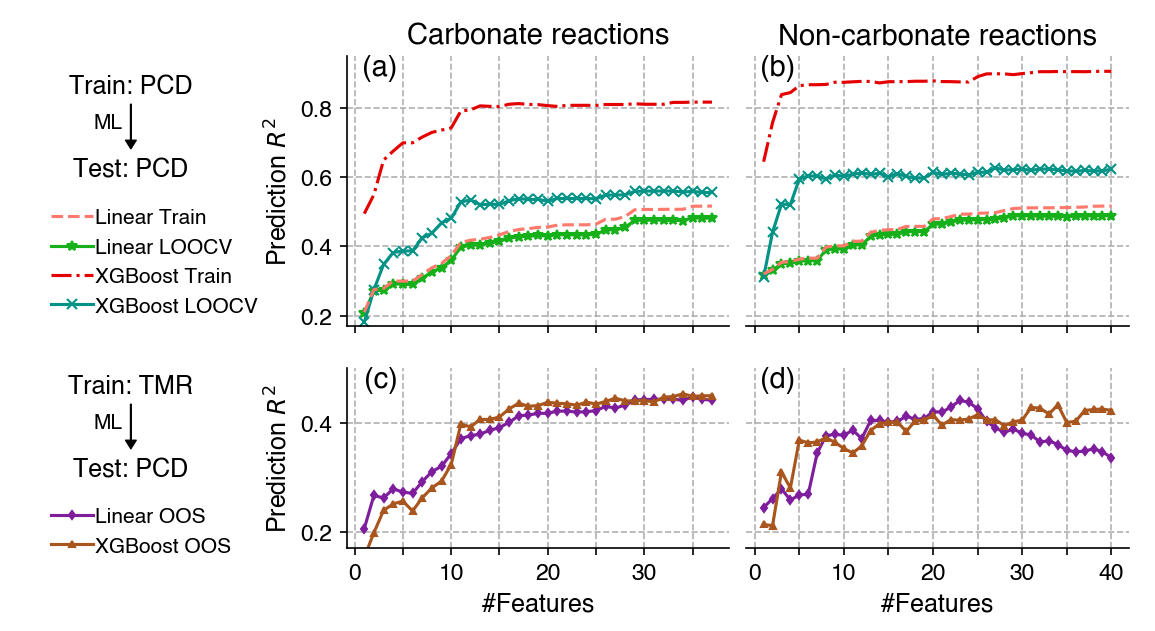

In [164]:
fig = plt.figure(figsize=(7.5, 4), dpi=150)
ax1 = fig.add_axes([0.295, 0.48, 0.34, 0.45])
ax2 = fig.add_axes([0.650, 0.48, 0.34, 0.45])

ax3 = fig.add_axes([0.295, 0.11, 0.34, 0.30])
ax4 = fig.add_axes([0.650, 0.11, 0.34, 0.30])

legend_format = {'fontsize': 10, 'fancybox': False, 'frameon': False, #'ncol': 2, 
                 'facecolor': 'white', 'framealpha': 1.0, 'edgecolor': 'none',
                 'columnspacing': 0.6, 'bbox_to_anchor': [-0.8, 0.0],
                 'borderpad': 0., 'handletextpad': 0.1, 'loc': 'lower left'}

ax1.plot(list(range(1, len(pcd_linear_temp_co_train)+1)), pcd_linear_temp_co_train['Train'], zorder=100, color='xkcd:salmon', linestyle='--', label='Linear Train')
ax1.plot(list(range(1, len(pcd_linear_temp_co_train)+1)), pcd_linear_temp_co_train['Valid'], '*-', color='xkcd:green', markersize=5, label='Linear LOOCV')

ax1.plot(list(range(1, len(pcd_xgboost_temp_co_train)+1)), pcd_xgboost_temp_co_train['Train'], linestyle='dashdot', color='xkcd:red',label='XGBoost Train')
ax1.plot(list(range(1, len(pcd_xgboost_temp_co_train)+1)), pcd_xgboost_temp_co_train['Valid'], 'x-', color='xkcd:teal', markersize=5, label='XGBoost LOOCV')

# ax1.text(35, 0.83, 'XGBoost Train', ha='right', fontsize=11)
# ax1.text(35, 0.58, 'Linear Train', ha='right', fontsize=11)
# ax1.text(27, 0.47, 'XGBoost LOOCV', ha='right', fontsize=11)
# ax1.text(27, 0.35, 'Linear LOOCV', ha='right', fontsize=11)

# ax1.set_xlabel('#Features', fontsize=12)
ax1.set_ylabel('Prediction $R^2$', fontsize=12)
ax1.set_title('Carbonate reactions', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.grid('on', linestyle='--')
ax1.set_ylim([0.17, 0.95])
ax1.set_xticks(list(range(0, 40, 5)))
ax1.set_xticklabels(['' for x in range(0, 40, 5)])
# ax1.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 40, 5)], fontsize=11)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.plot(list(range(1, len(pcd_linear_temp_oo_train)+1)), pcd_linear_temp_oo_train['Train'], zorder=100, color='xkcd:salmon', linestyle='--', label=' Linear Train')
ax2.plot(list(range(1, len(pcd_linear_temp_oo_train)+1)), pcd_linear_temp_oo_train['Valid'], '*-', color='xkcd:green', markersize=5, label=' Linear LOOCV')

ax2.plot(list(range(1, len(pcd_xgboost_temp_oo_train)+1)), pcd_xgboost_temp_oo_train['Train'], linestyle='dashdot', color='xkcd:red', label=' XGBoost Train')
ax2.plot(list(range(1, len(pcd_xgboost_temp_oo_train)+1)), pcd_xgboost_temp_oo_train['Valid'], 'x-', color='xkcd:teal', markersize=5, label=' XGBoost LOOCV ')

# ax2.text(38, 0.83, 'XGBoost Train', ha='right', fontsize=11)
# ax2.text(38, 0.64, 'Linear Train', ha='right', fontsize=11)
# ax2.text(27, 0.51, 'XGBoost LOOCV', ha='right', fontsize=11)
# ax2.text(27, 0.38, 'Linear LOOCV', ha='right', fontsize=11)

ax3.plot(list(range(1, len(pcd_linear_temp_co_oos)+1)), pcd_linear_temp_co_oos['Valid'], 'd-', color='xkcd:purple', markersize=3, label='Linear OOS')
ax3.plot(list(range(1, len(pcd_xgboost_temp_co_oos)+1)), pcd_xgboost_temp_co_oos['Valid'], '^-', color='xkcd:sienna', markersize=3, label='XGBoost OOS')
ax4.plot(list(range(1, len(pcd_linear_temp_oo_oos)+1)), pcd_linear_temp_oo_oos['Valid'], 'd-', color='xkcd:purple', markersize=3, label=' Linear OOS')
ax4.plot(list(range(1, len(pcd_xgboost_temp_oo_oos)+1)), pcd_xgboost_temp_oo_oos['Valid'], '^-', color='xkcd:sienna', markersize=3, label=' XGBoost OOS')

# ax2.set_xlabel('#Features', fontsize=12)

ax1.legend(**legend_format)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='y', which='both',length=0)
ax2.grid('on', linestyle='--')
ax2.set_xticks(list(range(0, 41, 5)))
ax2.set_xticklabels(['' for x in range(0, 41, 5)])
# ax2.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 41, 5)], fontsize=11)
ax2.set_ylim([0.17, 0.95])
ax2.set_yticklabels([])
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title('Non-carbonate reactions', fontsize=14)

ax3.set_xlabel('#Features', fontsize=12)
ax3.set_ylabel('Prediction $R^2$', fontsize=12)
ax3.tick_params(axis='both', which='major', labelsize=11)
ax3.grid('on', linestyle='--')
ax3.set_ylim([0.17, 0.50])
ax3.set_xticks(list(range(0, 40, 5)))
ax3.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 40, 5)], fontsize=11)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

legend_format.update({'bbox_to_anchor': [-0.8, -0.1]})

ax4.set_xlabel('#Features', fontsize=12)
ax3.legend(**legend_format)
ax4.tick_params(axis='both', which='major', labelsize=11)
ax4.tick_params(axis='y', which='both',length=0)
ax4.grid('on', linestyle='--')
ax4.set_xticks(list(range(0, 41, 5)))
ax4.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 41, 5)], fontsize=11)
ax4.set_ylim([0.17, 0.50])
ax4.set_yticklabels([])
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax_labels = fig.add_axes([0, 0, 1, 1])
ax_labels.text(0.340, 0.91, '(a)', ha='right', va='center', fontsize=14)
ax_labels.text(0.694, 0.91, '(b)', ha='right', va='center', fontsize=14)
ax_labels.text(0.340, 0.39, '(c)', ha='right', va='center', fontsize=14)
ax_labels.text(0.694, 0.39, '(d)', ha='right', va='center', fontsize=14)

ax_labels.text(0.103, 0.86, 'Train: PCD', ha='center', va='bottom', fontsize=12)
ax_labels.text(0.103, 0.72, 'Test: PCD', ha='center', va='bottom', fontsize=12)
ax_labels.text(0.103, 0.36, 'Train: TMR', ha='center', va='bottom', fontsize=12)
ax_labels.text(0.103, 0.22, 'Test: PCD', ha='center', va='bottom', fontsize=12)
ax_labels.arrow(0.103, 0.85, 0, -0.06, linewidth=0.5, head_width=0.01,
               facecolor='k')
ax_labels.arrow(0.103, 0.35, 0, -0.06, linewidth=0.5, head_width=0.01,
               facecolor='k')
ax_labels.text(0.07, 0.81, 'ML', fontsize=10)
ax_labels.text(0.07, 0.31, 'ML', fontsize=10)

ax_labels.patch.set_alpha(0.0)
ax_labels.set_xlim([0, 1])
ax_labels.set_ylim([0, 1])
ax_labels.set_xticks([])
ax_labels.set_yticks([])
[v.set_visible(False) for v in ax_labels.spines.values()]

plt.savefig('figures/Fig.5.OOS.pdf')
plt.show()

#### Make plot (Fig. S4)

Carbonate reactions: TMR 3182 PCD 2343
Oxide reactions: TMR 3143 PCD 3064


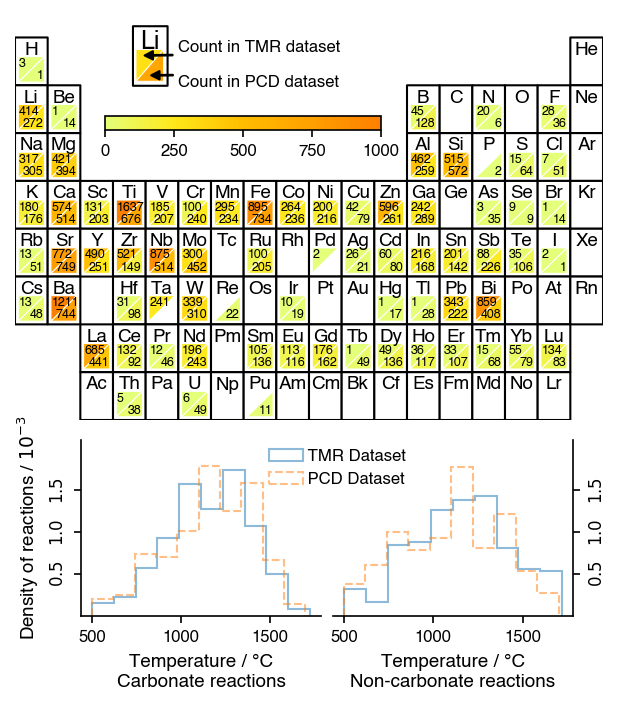

In [8]:
from s4.ml.plotting import periodic_table_heatmap_sbs
from s4.ml.plotting import periodic_table_heatmap_sbs
from matplotlib.colors import to_rgb
from s4.ml.plotting import generate_pt_triangulation

def draw_example(ax):
    tri_x, tri_y, tri_upper, tri_lower = generate_pt_triangulation(1, {1: 0})
    ax.pcolor(
        numpy.arange(2),
        numpy.arange(2) * 1.5,
        numpy.zeros((1, 1)),
        cmap='binary',
        # alpha=0.0,
        edgecolors="k",
        linewidths=1.,
        vmin=0,
        vmax=1,
    )
    heatmap = ax.tripcolor(
        tri_x, -tri_y, tri_upper[:1] + tri_lower[:1],
        [0.3, 0.7],
        cmap='Wistia',
        edgecolors="white",
        linewidths=0.5,
        vmin=0,
        vmax=1,
    )
    ax.text(
        0.5,
        0.4,
        'Li',
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=12,
        color='k',
    )
    ax.set_xlim([-0.1, 2.5])
    ax.set_ylim([-0.1, 1.6])
    ax.axis("off")
    ax.invert_yaxis()
    
    ax.annotate('Count in TMR dataset', 
                xy=(0.3, 0.75),  xycoords='data',
                xytext=(0.55, 0.73), textcoords='axes fraction', fontsize=8,
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=4),
                ha='left', verticalalignment='top',
    )
    ax.annotate('Count in PCD dataset', 
                xy=(0.5, 1.25),  xycoords='data',
                xytext=(0.55, 0.21), textcoords='axes fraction', fontsize=8,
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=4),
                ha='left', verticalalignment='top',
    )
    
fig = plt.figure(figsize=(4, 4.5), dpi=150)

heatmap_pcd = Counter()
for comp in (
    sum(pcd_carb_oxi.meta_precursors.values.tolist(), ()) +
    sum(pcd_oxi_oxi.meta_precursors.values.tolist(), ())):
    for k in C(comp):
        if k.symbol not in {'C', 'O'}:
            heatmap_pcd[k.symbol] += 1

heatmap_dmm = Counter()
for comp in (
    sum(carb_oxi.meta_precursors.values.tolist(), ()) +
    sum(oxi_oxi.meta_precursors.values.tolist(), ())):
    for k in C(comp):
        if k.symbol not in {'C', 'O'}:
            heatmap_dmm[k.symbol] += 1

pt_ax = fig.add_axes([0.01, 0.41, 0.98, 0.60])
cbar_ax = fig.add_axes([0.16, 0.84, 0.46, 0.02])
example_ax = fig.add_axes([0.2, 0.9, 0.15, 0.1])
ax1 = fig.add_axes([0.12, 0.12, 0.40, 0.26])
ax2 = fig.add_axes([0.54, 0.12, 0.40, 0.26])

draw_example(example_ax)

periodic_table_heatmap_sbs(heatmap_dmm, heatmap_pcd, cmap="Wistia",
                           value_format='\n%d', cmap_range=(0, 1000),
                           include_rows={1, 2, 3, 4, 5, 6, 8, 9},
                           cbar_label_size=8, cax=cbar_ax, ax=pt_ax)

legend_format = {
    'fontsize': 8, 'fancybox': False, 'frameon': False, 
    'borderpad': 0., 'handletextpad': 0., 'loc': 'upper left',
    'bbox_to_anchor': [-0.3, 1.0]}

print('Carbonate reactions: TMR %d PCD %d' % (len(carb_oxi), len(pcd_carb_oxi)))
print('Oxide reactions: TMR %d PCD %d' % (len(oxi_oxi), len(pcd_oxi_oxi)))

ax1.hist(carb_oxi.y_temperature, 
         bins=10, histtype='step', density=True, alpha=0.5, label=' TMR Dataset')
ax1.hist(pcd_carb_oxi.y_temperature, 
         bins=10, histtype='step', linestyle='--', density=True, alpha=0.5, label=' PCD Dataset')
ax1.set_xlabel('Temperature / °C\nCarbonate reactions', fontsize=9)
ax1.set_ylabel('Density of reactions / $10^{-3}$', fontsize=9)
ax1.set_ylim([0.0, 2.1e-3])
ax1.set_yticks([0.5e-3, 1.0e-3, 1.5e-3])
ax1.set_yticklabels(['$0.5$', '$1.0$', '$1.5$'], rotation=90, fontsize=8, va='center')
ax1.set_xticks([500, 1000, 1500])
ax1.set_xticklabels(['500', '1000', '1500'], fontsize=8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.hist(oxi_oxi.y_temperature, 
         bins=10, histtype='step', alpha=0.5, density=True, label=' TMR Dataset')
ax2.hist(pcd_oxi_oxi.y_temperature, 
         bins=10, histtype='step', linestyle='--', alpha=0.5, density=True, label=' PCD Dataset')
ax2.set_xlabel('Temperature / °C\nNon-carbonate reactions', fontsize=9)
ax2.set_ylim([0.0, 2.1e-3])
ax2.set_yticks([0.5e-3, 1.0e-3, 1.5e-3])
ax2.set_yticklabels(['$0.5$', '$1.0$', '$1.5$'], rotation=90, fontsize=8, va='center')
ax2.yaxis.tick_right()
ax2.set_xticks([500, 1000, 1500])
ax2.set_xticklabels(['500', '1000', '1500'], fontsize=8)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
# ax2.set_title('Oxide/oxide reactions', fontsize=10)
# ax2.set_ylim([0, 260])
ax2.legend(**legend_format)
plt.savefig('figures/Fig.S4.PCD-DMM.pdf')
plt.show()

## Manuscript discussion

### (Sec. Discussion.1) Temperature: Tamman's rule (Fig. D1)

In [28]:
tamman_co_result = sm.wls(
    formula=f"y_temperature ~ feature_exp_mean_mp", data=carb_oxi,
    weights=1.0/(1+numpy.log(carb_oxi['meta_precursor_freq'].values))**2,
).fit()

# tamman_co_result = sm.ols(
#     formula=f"y_temperature ~ feature_exp_mean_mp", data=carb_oxi,
# ).fit()

tamman_oo_result = sm.wls(
    formula=f"y_temperature ~ feature_exp_mean_mp", data=oxi_oxi,
    weights=1.0/(1+numpy.log(oxi_oxi['meta_precursor_freq'].values))**2,
).fit()

# tamman_oo_result = sm.ols(
#     formula=f"y_temperature ~ feature_exp_mean_mp", data=oxi_oxi,
# ).fit()

print('Carbonate/oxide reactions result: Tamman\'s rule')
print(tamman_co_result.summary())
print('Oxide/oxide reactions result: Tamman\'s rule')
print(tamman_oo_result.summary())

print('SS table')
print('Carbonate/oxide RSS:', f'{tamman_co_result.ssr:.2g}')
print('Carbonate/oxide TSS:', f'{tamman_co_result.centered_tss:.2g}')
print('Oxide/oxide RSS:', f'{tamman_oo_result.ssr:.2g}')
print('Oxide/oxide TSS:', f'{tamman_oo_result.centered_tss:.2g}')

Carbonate/oxide reactions result: Tamman's rule
                            WLS Regression Results                            
Dep. Variable:          y_temperature   R-squared:                       0.227
Model:                            WLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     931.7
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          1.08e-179
Time:                        18:00:55   Log-Likelihood:                -22788.
No. Observations:                3182   AIC:                         4.558e+04
Df Residuals:                    3180   BIC:                         4.559e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

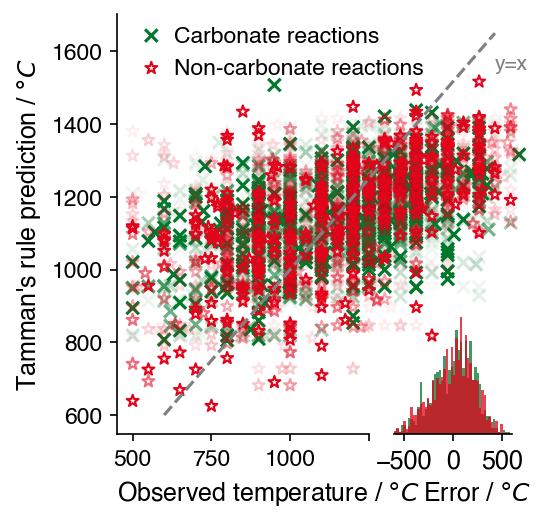

In [29]:
from s4.ml.utils import weights2colors

fig = plt.figure(figsize=(3.5, 3.5), dpi=150)

ax1 = fig.add_axes([0.20, 0.15, 0.78, 0.80])
ax2 = fig.add_axes([0.69, 0.15, 0.3, 0.3])

ax1.plot([600, 1650], [600, 1650], color='gray', linestyle='--')
ax1.text(1650, 1550, 'y=x', fontsize=10, color='gray')

# Carbonate/oxide
ax1.scatter(
    x=tamman_co_result.resid + tamman_co_result.fittedvalues, 
    y=tamman_co_result.fittedvalues, 
    color=weights2colors(1.0/(1+numpy.log(carb_oxi['meta_precursor_freq'].values))**2, base_color='#00792c'), 
    marker='x', label='Carbonate reactions')
# Oxide
ax1.scatter(
    tamman_oo_result.resid + tamman_oo_result.fittedvalues, 
    tamman_oo_result.fittedvalues, 
    edgecolors=weights2colors(1.0/(1+numpy.log(oxi_oxi['meta_precursor_freq'].values))**2, base_color='#e3031b'), 
    marker='*', facecolor='none', label='Non-carbonate reactions')

legend_format = {'fontsize': 11, 'fancybox': False, 'frameon': False, 'borderpad': 0., 'handletextpad': 0., 'loc': 'upper left'}
for lh in ax1.legend(**legend_format).legendHandles: 
    lh.set_alpha(1)

ax1.set_xlabel('Observed temperature / $°C$', fontsize=12, loc='left')
ax1.set_ylabel("Tamman's rule prediction / $°C$", fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_bounds(450, 1250)
ax1.set_xticks([500, 750, 1000, 1250])
ax1.set_xticklabels([500, 750, 1000, ''])
ax1.set_xlim([450, 1750])

ax2.hist(tamman_co_result.resid, bins=50, color='#00792c', density=True, 
         alpha=0.75, range=(-600, 600), label='Adj. $R^2$ = %.2f' % tamman_co_result.rsquared_adj)
ax2.hist(tamman_oo_result.resid, bins=50, color='#e3031b', density=True, 
         alpha=0.75, range=(-600, 600), label='Adj. $R^2$ = %.2f' % tamman_oo_result.rsquared_adj)

ax2.set_xlabel('Error / $°C$', fontsize=12, loc='right')
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_yticks([])
ax2.set_xlim([-800, 800])
ax2.patch.set_alpha(0.0)
[v.set_visible(False) for k, v in ax2.spines.items() if k != 'bottom']
ax2.spines['bottom'].set_bounds(-600, 600)
ax2.set_ylim([0, 0.0036])

plt.savefig('figures/Fig.D1.Tamman_Fitting.pdf')
plt.show()

### (Sec. Results.1) Detection of heteroskedasticity (Fig. S1)

                            OLS Regression Results                            
Dep. Variable:                  std_y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     41.32
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           4.07e-10
Time:                        15:55:47   Log-Likelihood:                -2139.6
No. Observations:                 365   AIC:                             4283.
Df Residuals:                     363   BIC:                             4291.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.6001     13.458     -0.119   

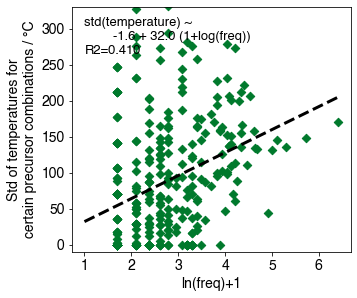

In [325]:
def test_heteroskedasticity(df, group_var='meta_precursor_freq', y_var='y_temperature', add_labels=False):
    """
    Detect heteroskedasticity in data and try to fix it using precursor popularity.

    Args:
        df: Input data frame.
        group_var: Variable name to group with.
        y_var: Dependent variable name.
        add_labels: Whether to add labels of each point on the plot.
    """
    std_y = df.groupby('meta_precursors').std()[y_var]
    htrske_df = pandas.DataFrame({
        'std_y': std_y,
        'adj_log_freq': 1+numpy.log(df.groupby('meta_precursors').mean()[group_var].values)
    }, index=std_y.index)

    ols_result = sm.ols(formula=f"std_y ~ adj_log_freq", data=htrske_df).fit()

    print(ols_result.summary())

    plt.figure(figsize=(5, 4.5))
    x_range = [min(htrske_df.adj_log_freq), max(htrske_df.adj_log_freq)]
    plt.plot(
        x_range, [x*ols_result.params['adj_log_freq'] for x in x_range], 
        '--', linewidth=3, color='k'
    )
    plt.scatter(htrske_df.adj_log_freq, htrske_df.std_y, marker='D', facecolor='#00792c')
    plt.xlabel('ln(freq)+1', fontsize=14)
    plt.ylabel('Std of temperatures for\ncertain precursor combinations / °C', fontsize=14)
    plt.gca().tick_params(axis='both', which='major', labelsize=14)
    
    if add_labels:
        for i, name in enumerate(htrske_df.index.values):
            if numpy.isfinite(htrske_df.std_y[i]):
                plt.text(htrske_df.adj_log_freq[i], htrske_df.std_y[i], '%s/%s' % name, fontsize=7)

    intercept, slope = ols_result.params['Intercept'], ols_result.params['adj_log_freq']
    plt.text(1, 265, f'std(temperature) ~ \n        {intercept:.1f} + {slope:.1f} (1+log(freq))\nR2=0.410', fontsize=13)
    plt.ylim([-10, 330])

    plt.show()
    
test_heteroskedasticity(carb_oxi, add_labels=False)
# test_heteroskedasticity(oxi_oxi.query('feature_ele_Si == False'))

In [58]:
# mean_val = carbonate_and_oxides_multistep.groupby('meta_precursors').mean()
# std_val = carbonate_and_oxides_multistep.groupby('meta_precursors').std()

# mean_val['y_temperature_std'] = std_val['y_temperature']
# mean_val['meta_precursor_freq'] = numpy.log(mean_val['meta_precursor_freq'])
# mean_val = mean_val.dropna()

# test_domreg = Dominance(
#     data=mean_val[all_possible_features_temperature + ['meta_precursor_freq', 'y_temperature_std']], 
#     target='y_temperature_std', 
#     top_k_features=15)
# test_domreg_result = test_domreg.incremental_rsquare()

# test_domreg.dominance_stats() \
#     .apply(pandas.to_numeric) \
#     .style.background_gradient(cmap ='coolwarm', axis=0)

In [59]:
# mean_val = oxides_multistep.groupby('meta_precursors').mean()
# std_val = oxides_multistep.groupby('meta_precursors').std()

# mean_val['y_temperature_std'] = std_val['y_temperature']
# mean_val['meta_precursor_freq'] = numpy.log(mean_val['meta_precursor_freq'])

# mean_val = mean_val.dropna()

# test_domreg = Dominance(
#     data=mean_val[all_possible_features_temperature + ['meta_precursor_freq', 'y_temperature_std']], 
#     target='y_temperature_std', 
#     top_k_features=15)
# test_domreg_result = test_domreg.incremental_rsquare()

# test_domreg.dominance_stats() \
#     .apply(pandas.to_numeric) \
#     .style.background_gradient(cmap ='coolwarm', axis=0)

### (Sec Discussion 1.2) BaCO3 + TiO2 example (Fig. D2)

In [87]:
target_reaction = carb_oxi.query("meta_doi == '10.1016/j.matlet.2018.03.008'")
target_reaction

,,meta_doi,meta_precursors,meta_text,y_speed,y_temperature,feature_ele_Li,feature_ele_Be,feature_ele_B,feature_ele_C,feature_ele_N,...,feature_max_p_h_300K,feature_diff_p_h_300K,feature_avg_dgf_300K,feature_min_dgf_300K,feature_max_dgf_300K,feature_diff_dgf_300K,feature_syn_n_precursors,feature_syn_n_carbonates,feature_syn_n_target_mixture,meta_precursor_freq
meta_k,meta_i,,,,,,,,,,,,,,,,,,,,,
9357,0,10.1016/j.matlet.2018.03.008,"(BaCO3, TiO2)",Barium titanate (BT) powder was prepared using...,-0.60206,1099.85,False,False,False,False,False,...,-9.784904,2.762316,-10.469579,-11.729311,-9.209848,2.519463,2,1,1,224


In [88]:
from s4.ml.wls import do_linear_model

only_tamman = do_linear_model(
    data_frame=carb_oxi, 
    features=['feature_exp_mean_mp'], 
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
)
print('Only tamman rule', only_tamman.predict(target_reaction).values)

# full_model_temp_co_csv = pandas.read_csv('intermediate_data/Full_Temp_CO_Params.csv').set_index('Unnamed: 0')['0']
elemental = [x.split('[')[0] for x in temp_co_feature_path if x.startswith('feature_ele')]

only_tamman = do_linear_model(
    data_frame=carb_oxi, 
    features=['feature_exp_mean_mp'] + elemental, 
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
)
print('With compositional features', only_tamman.predict(target_reaction).values)

only_tamman = do_linear_model(
    data_frame=carb_oxi, 
    features=['feature_exp_mean_mp', 'feature_text_is_multi_heating'] + elemental, 
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
)
print('With compositional+experimental features', only_tamman.predict(target_reaction).values)

Only tamman rule [1128.4995149]
With compositional features [1235.32422725]
With compositional+experimental features [1208.00166254]


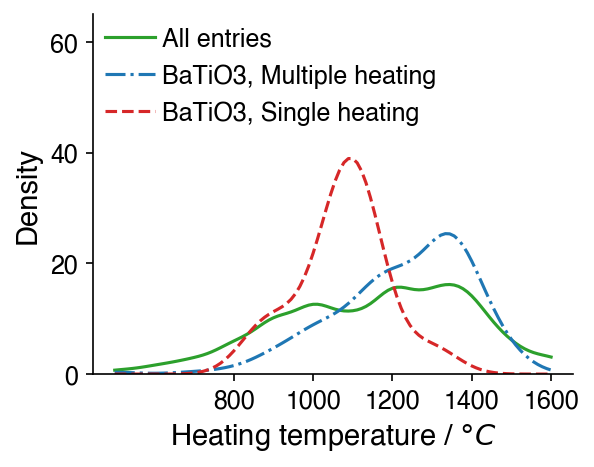

In [95]:
fig = plt.figure(figsize=(4, 3), dpi=150)

ax = fig.add_axes([0.15, 0.17, 0.8, 0.8])
from scipy.stats import gaussian_kde

BaCO3_TiO2 = carb_oxi.loc[carb_oxi.meta_precursors == ("BaCO3", "TiO2")]
# plt.hist(BaCO3_TiO2.query('feature_text_is_multi_heating == True').y_temperature, 
#          alpha=0.6, range=(500, 1600), bins=12, color='tab:blue')
# plt.hist(BaCO3_TiO2.query('feature_text_is_multi_heating == False').y_temperature, 
#          alpha=0.6, range=(500, 1600), bins=12, color='tab:red')

xrange = numpy.linspace(500, 1600, 100)

kernel = gaussian_kde(carb_oxi.y_temperature)
yrange = kernel(xrange)*10000
plt.plot(xrange, yrange, linestyle='-', color='tab:green', label=' All entries')

kernel = gaussian_kde(
    BaCO3_TiO2.query('feature_text_is_multi_heating == True').y_temperature
)
yrange = kernel(xrange)*10000
plt.plot(xrange, yrange, linestyle='-.', color='tab:blue', label=' BaTiO3, Multiple heating')

kernel = gaussian_kde(
    BaCO3_TiO2.query('feature_text_is_multi_heating == False').y_temperature
)
yrange = kernel(xrange)*10000
plt.plot(xrange, yrange, linestyle='--', color='tab:red', label=' BaTiO3, Single heating')

plt.xlabel('Heating temperature / $°C$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.gca().set_ylim([0, 65])
plt.gca().set_yticks(ticks=[0, 20, 40, 60])
plt.gca().set_yticklabels(labels=['0', '20', '40', '60'], fontsize=12)
plt.gca().set_xticks(ticks=[800, 1000, 1200, 1400, 1600])
plt.gca().set_xticklabels(labels=['800', '1000', '1200', '1400', '1600'], fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

legend_format = {
    'fontsize': 12, 'fancybox': False, 'frameon': False, 
    'borderpad': 0., 'handletextpad': 0., 'loc': 'upper left'}
plt.legend(**legend_format)
# plt.tight_layout()
plt.savefig('figures/Fig.D2.BaCO3-TiO2.pdf')
plt.show()

### (Sec. Discussion 2) Thermo lower/upper bounds

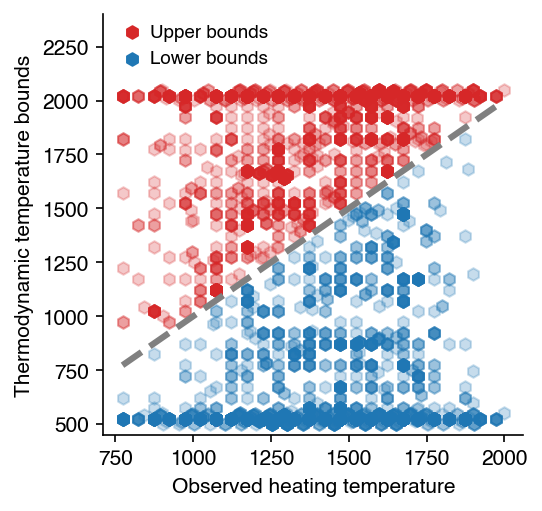

In [394]:
fig = plt.figure(figsize=(3.5, 3.3), dpi=150)
ax1 = fig.add_axes([0.18, 0.13, 0.8, 0.85])

ax1.scatter(carb_oxi.y_temperature+273.15, carb_oxi.feature_thermo_ub_temp*1000, 
            marker='h', color='tab:red', alpha=0.25, label='Upper bounds')
ax1.scatter(carb_oxi.y_temperature+273.15, carb_oxi.feature_thermo_lb_temp*1000, 
            marker='h', color='tab:blue', alpha=0.25, label='Lower bounds')
ax1.text(1750, 1750, '')
ax1.plot([500+273.15, 1700+273.15], [500+273.15, 1700+273.15], '--', color='gray', linewidth=3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(which='both', labelsize=10)
ax1.set_ylim([450, 2400])
ax1.legend()

legend_format = {'fontsize': 9, 'fancybox': False, 'frameon': False, 
                 'borderpad': 0., 'handletextpad': 0., 'loc': 'upper left'}
for lh in ax1.legend(**legend_format).legendHandles: 
    lh.set_alpha(1)
    
ax1.set_xlabel('Observed heating temperature', fontsize=10)
ax1.set_ylabel('Thermodynamic temperature bounds', fontsize=10)

plt.savefig('figures/Fig.D3.thermo_bounds.pdf')
plt.show()